# Packages, Heaviside- Funktion und Funktion der jeweils neuen Beschleunigung

In [1]:
#using Plots ; println("Plots geladen")
using PyPlot ; println("PyPlot geladen")
using Dates ; println("Dates geladen")
using CSV ; println("CSV geladen")
using DataFrames ; println("DataFrames geladen")

using ProgressMeter ; println("ProgressMeter geladen")
using InteractiveUtils ; println("InteractiveUtils geladen")
using Statistics ; println("Statistics geladen")

using LinearAlgebra ; println("LinearAlgebra geladen")
using Interpolations ; println("Interpolations geladen")


function heaviside(x)
    if x ≥ 0
        return 1
    elseif x < 0
        return 0
    else return NaN
    end
end

# Diese Funktion berechnet die neuen Beschleunigungen
# für jeden Zeitschritt

function new_accel_func(s, v, pos, v_syn, a_mx, d_par, τ_G, τ_safe,
        p1, p2, p3, p4)
    acceleration = 0
    lens = length(s)
    if pos == lens
        acceleration = a_mx
    else
        x_val   = s[pos]
        x_l_val = s[pos+1]
        v_val   = v[pos]
        v_l_val = v[pos+1]
        g       = x_l_val - x_val - d_par
        g_safe  = v_val * τ_safe
        G       = v_val * τ_G
        if g < g_safe
            acceleration = p1*(g-g_safe)+p2*(v_l_val-v_val)
        elseif g_safe ≤ g ≤ G
            acceleration = p3*(v_l_val-v_val) + p4*heaviside(v_val-v_syn)
        else # das deckt g > G ab
            acceleration = a_mx
        end
        acceleration = min(acceleration, a_mx) ### Hinweis: Hier wird sichergestellt, dass a tatsächlich a_max nicht
        # überschreitet.
    end
    return acceleration
end

PyPlot geladen
Dates geladen
CSV geladen
DataFrames geladen
ProgressMeter geladen
InteractiveUtils geladen
Statistics geladen
LinearAlgebra geladen
Interpolations geladen


new_accel_func (generic function with 1 method)

In [3]:
q_in   = 0.625
v_max  = 33 + 1/3
τ_G    = 3
τ_safe = 1
d      = 7.5

a1 = v_max / q_in - d ; println(a1)
#(33 + 1/3) / 0.625 - 7.5 #v * τ_in

τ_G * v_max , τ_safe * v_max

45.833333333333336


(100.0, 33.333333333333336)

In [5]:
##########################################################################
### Zeitentwicklung für n_tsteps Zeitschritte
##########################################################################

function Zeitentw_Funk(L, q_in, v_syn, v_init, v_mx, a_mx, d_par, τ_G, τ_safe,
        p1, p2, p3, p4, t_step, t_end,
        L_m, λ_b, x_on_b, q_on_b,
        x_on_b_down, q_on_b_down0, q_on_b_down1, t_on_b_down_start, t_on_b_down_duration)

    ####################################################################################
    ### Variablen und Kontrollparameter initialisieren
    ####################################################################################
    last_t_Index = Int64(round(t_end/t_step))
    t_vec = []
    s_vec = []                  ; push!(s_vec, [])
    v_vec = []                  ; push!(v_vec, [])
    a_vec = []                  ; push!(a_vec, [])
    vehicle_n_vec = []          ; push!(vehicle_n_vec, [])
    emitted_cars_vec = []
    
    new_car_control_param           = 0
    b_control_param                 = 0
    b_down_control_param            = 0
    pos_Index_b1                    = 0
    #pos_Index_b1_control_param      = 0
    pos_Index_b2                    = 0
    pos_Index_b_down1               = 0
    #pos_Index_b_down1_control_param = 0
    pos_Index_b_down2               = 0
    
    bottleneck_b      = []
    bottleneck_b_down = []
    #break_time_control_param1 = 0
    #break_time_control_param2 = 0
    #n_the_breaking_guy = 0
    #Index_breakman_temp = Index_breakman
    
    ####################################################################################
    ### Anfagszustand initialisieren
    ####################################################################################
    initial_distance = v_init / q_in
    Rest = mod(L, initial_distance)
    first_car_loc = L - Rest
    N_initial_occupation = Int64(round(((L - Rest)/initial_distance + 1)))
    new_car_number = N_initial_occupation
    
    push!(t_vec, 0)
    for i in 1 : N_initial_occupation
        insert!(s_vec[1],         1, first_car_loc-(i-1)*initial_distance)
        insert!(v_vec[1],         1, v_init)
        insert!(a_vec[1],         1, 0)
        insert!(vehicle_n_vec[1], 1, i)
    end #f48
    
    for pos_I in 1 : N_initial_occupation
        runback_Index = N_initial_occupation + 1 - pos_I
        if pos_Index_b1 == 0 || pos_Index_b2 == 0 || pos_Index_b_down1 == 0 || pos_Index_b_down2 == 0
            if s_vec[1][runback_Index] < (x_on_b_down + L_m) && pos_Index_b_down2 == 0
                pos_Index_b_down2 = runback_Index
# diesen Index wird das gerade eingesetzte Auto in s_vec für t=0 haben, nachdem alle Autos eingesetzt wurden (Referenz x1)
            elseif s_vec[1][runback_Index] < x_on_b_down && pos_Index_b_down1 == 0
                pos_Index_b_down1 = runback_Index # siehe Referenz x1

            elseif s_vec[1][runback_Index] < (x_on_b + L_m) && pos_Index_b2 == 0
                pos_Index_b2 = runback_Index # siehe Referenz x1

            elseif s_vec[1][runback_Index] < x_on_b && pos_Index_b1 == 0
                pos_Index_b1 = runback_Index # siehe Referenz x1
            end #i54
        else
            break
        end
    end
    #pos_Index_b1 = 5 # Cheat - Benjamin Blümchen
    cars_from_road_inflow = N_initial_occupation + q_in * t_end
    number1 = log(cars_from_road_inflow) / log(10)
    number2 = Int(10^ceil(number1))
    n_new_car_in_b      = 1 * number2
    n_new_car_in_b_down = 2 * number2
    println("Zu Beginn der Simulation ist") ; println("pos_Index_b1      = $pos_Index_b1") ; 
    println("pos_Index_b2      = $pos_Index_b2")
    println("pos_Index_b_down1 = $pos_Index_b_down1") ; println("pos_Index_b_down2  = $pos_Index_b_down2")
    ####################################################################################
    ### Zeitentwicklung durchführen
    ####################################################################################
    for t_Index in 1:last_t_Index
        t_ArIndex = t_Index + 1
        time = t_Index*t_step
        
        push!(t_vec, time)
        push!(s_vec, []) ; push!(v_vec, []) ; push!(a_vec, []) ; push!(vehicle_n_vec, [])
        for j in 1: length(s_vec[t_ArIndex - 1])
            push!(s_vec[t_ArIndex],[])
            push!(v_vec[t_ArIndex],[])
            push!(a_vec[t_ArIndex],[])
        end #f83
        vehicle_n_vec[t_ArIndex] = deepcopy(vehicle_n_vec[t_ArIndex - 1])
        
        s = s_vec[t_ArIndex - 1]
        v = v_vec[t_ArIndex - 1]
        #########################################################################################################
        ### neue Beschleunigung berechnen
        #########################################################################################################
        for pos_Index in 1:length(s_vec[t_ArIndex - 1])
            pos = pos_Index
            acc = new_accel_func(s, v, pos, v_syn, a_mx, d_par, τ_G, τ_safe, p1, p2, p3, p4)
            a_vec[t_ArIndex - 1][pos_Index] = acc
        end #f95
        # Die Berechnung von a, v und s wird nach folgendem Grundschema durchgeführt:
        # a_values(t) = f(s_values(t), v_values(t))
        # v(t+1) = v(t) + a(t) * Δt
        # v(t+1) = v(t) + a(t) * Δt
        # s_values(t), v_values(t) und a_values(t) sind Vektoren, die alle Orts-, Geschwindigkeits- und
        # Beschleunigungswerte zum Zeitpunkt t enthalten. Im Algorithmus wurden jedoch alle t-Indizes um 1 verringert.
        # Die Abbildungsfunktion f ist hier durch die obige for-Schleife über alle Ortsindizes ("pos_Index") realisiert.
        #########################################################################################################
        ### neue Geschwindigkeit berechnen
        #########################################################################################################
        for pos_Index in 1:length(s_vec[t_ArIndex - 1])
            vel     = v_vec[t_ArIndex - 1][pos_Index] + t_step * a_vec[t_ArIndex - 1][pos_Index]
            vel_cor = min(vel , v_mx)
            v_vec[t_ArIndex][pos_Index] = vel_cor
        end #f110
        #########################################################################################################
        ### neuen Ort berechnen
        #########################################################################################################
        for pos_Index in 1:length(s_vec[t_ArIndex - 1])
            loc = s_vec[t_ArIndex - 1][pos_Index] + t_step * v_vec[t_ArIndex - 1][pos_Index]
            s_vec[t_ArIndex][pos_Index] = loc
        end #f118
        
        
        if s_vec[t_ArIndex][pos_Index_b_down2] ≥ (x_on_b_down + L_m)
            pos_Index_b_down2 = pos_Index_b_down2 - 1
        end #i124
        if s_vec[t_ArIndex][pos_Index_b_down1] ≥ x_on_b_down
            pos_Index_b_down1 = pos_Index_b_down1 - 1
        end #i127
        if s_vec[t_ArIndex][pos_Index_b2] ≥ (x_on_b + L_m)
            pos_Index_b2 = pos_Index_b2 - 1
        end #i130
        #println("pos_Index_b1 decremented to $pos_Index_b1 before time $time")
        if s_vec[t_ArIndex][pos_Index_b1] ≥ x_on_b
            pos_Index_b1 = pos_Index_b1 - 1
            #pos_Index_b1 = pos_Index_b1 - 1
        end #i133
        #########################################################################################################
        ### Autos am Ende der Straße entfernen (oberes Ende der Straße)
        #########################################################################################################
        for pos_Index in 1:length(s_vec[t_ArIndex])
            back_run_Index = length(s_vec[t_ArIndex]) + 1 - pos_Index
            if s_vec[t_ArIndex][back_run_Index] > L
                pop!(s_vec[t_ArIndex])
                pop!(v_vec[t_ArIndex])
                pop!(a_vec[t_ArIndex])
                emitted_car = vehicle_n_vec[t_ArIndex][length(vehicle_n_vec[t_ArIndex])]
                pop!(vehicle_n_vec[t_ArIndex])
                push!(emitted_cars_vec, emitted_car)
            elseif s_vec[t_ArIndex][back_run_Index] ≤ L
                break
            end #i141
        end #f139
        #########################################################################################################
        ### neue Autos auf die Straße setzen (am unteren Ende der Straße)
        #########################################################################################################
        new_car_control_param = new_car_control_param + q_in * t_step
        if new_car_control_param ≥ 1
            new_car_number = new_car_number + 1

            # Auto einsetzen
            insert!(s_vec[t_ArIndex],         1, 0)
            insert!(vehicle_n_vec[t_ArIndex], 1, new_car_number)
            insert!(v_vec[t_ArIndex],         1, v_init)
            insert!(a_vec[t_ArIndex],         1, 0)
            
            pos_Index_b1      = pos_Index_b1 + 1
            pos_Index_b2      = pos_Index_b2 + 1
            pos_Index_b_down1 = pos_Index_b_down1 + 1
            pos_Index_b_down2 = pos_Index_b_down2 + 1
            
            new_car_control_param = new_car_control_param - 1
        end #i156
        #########################################################################################################
        ### neue Autos von Zubringer (bottleneck) b auf die Straße setzen
        #########################################################################################################        
        b_control_param = b_control_param + q_on_b * t_step
        if b_control_param ≥ 1
            n_new_car_in_b = n_new_car_in_b + 1
            push!(bottleneck_b , n_new_car_in_b)
            b_control_param = b_control_param - 1
        end #i176
        if length(bottleneck_b) > 0
            # Einfügebefehl Auo vom Zubringer b auf die Straße
            for Ortsindex in pos_Index_b1 : pos_Index_b2
                if s_vec[t_ArIndex][Ortsindex+1] - s_vec[t_ArIndex][Ortsindex] -2*d_par > λ_b*v_vec[t_ArIndex][Ortsindex+1]
                    loc = (s_vec[t_ArIndex][Ortsindex+1] + s_vec[t_ArIndex][Ortsindex]) / 2
                    
                    if x_on_b ≤ loc ≤ (x_on_b + L_m)
                        velocity     = v_vec[t_ArIndex][Ortsindex+1]
                        acceleration = 0
                        car_number   = bottleneck_b[1]
                        deleteat!(bottleneck_b , 1)

                        insert!(s_vec[t_ArIndex],         (Ortsindex+1), loc)
                        insert!(v_vec[t_ArIndex],         (Ortsindex+1), velocity)
                        insert!(a_vec[t_ArIndex],         (Ortsindex+1), acceleration)
                        insert!(vehicle_n_vec[t_ArIndex], (Ortsindex+1), car_number)
                        
                        pos_Index_b_down1 = pos_Index_b_down1 + 1
                        pos_Index_b_down2 = pos_Index_b_down2 + 1
                        if loc < s_vec[t_ArIndex][pos_Index_b2]
                            pos_Index_b2 = pos_Index_b2 + 1
                        end #i200
                    end #i187
                end #i184
                if length(bottleneck_b) == 0
                    break
                end #i205
            end #f183
        end #i181
        #########################################################################################################
        ### neue Autos von Zubringer (bottleneck) b_down auf die Straße setzen
        #########################################################################################################        
        if t_on_b_down_start ≤ time ≤ (t_on_b_down_start + t_on_b_down_duration)
            b_down_control_param = b_down_control_param + q_on_b_down1 * t_step
            if b_down_control_param ≥ 1
                n_new_car_in_b_down = n_new_car_in_b_down + 1
                push!(bottleneck_b_down , n_new_car_in_b_down)
                b_down_control_param = b_down_control_param - 1
            end #i215
        end #i213 #############################################################################################
        if t_on_b_down_start ≤ time ≤ (t_on_b_down_start + 1.1 * t_on_b_down_duration) && length(bottleneck_b_down) > 0
            # ein bisschen Zeit geben, damit das Auto noch den Zubringer verlassen kann.

            
            # Einfügebefehl Auto vom Zubringer b_down auf die Straße
            for Ortsindex in pos_Index_b_down1 : pos_Index_b_down2
                if s_vec[t_ArIndex][Ortsindex+1] - s_vec[t_ArIndex][Ortsindex] -2*d_par > λ_b*v_vec[t_ArIndex][Ortsindex+1]
                    loc = (s_vec[t_ArIndex][Ortsindex+1] + s_vec[t_ArIndex][Ortsindex]) / 2

                    if x_on_b_down ≤ loc ≤ (x_on_b_down + L_m)
                        velocity     = v_vec[t_ArIndex][Ortsindex+1]
                        acceleration = 0
                        car_number   = bottleneck_b_down[1]
                        deleteat!(bottleneck_b_down , 1)

                        insert!(s_vec[t_ArIndex],         (Ortsindex+1), loc)
                        insert!(v_vec[t_ArIndex],         (Ortsindex+1), velocity)
                        insert!(a_vec[t_ArIndex],         (Ortsindex+1), acceleration)
                        insert!(vehicle_n_vec[t_ArIndex], (Ortsindex+1), car_number)

                        if loc < s_vec[t_ArIndex][pos_Index_b_down2]
                            pos_Index_b_down2 = pos_Index_b_down2 + 1
                        end #i241
                    end #i230
                end #i227
                if length(bottleneck_b) == 0
                    break
                end #i246
            end #f226
        end #i221
    end #f78 (Zeitschleife)
    n_new_car_in_b_down = n_new_car_in_b_down - length(bottleneck_b_down)
    n_new_car_in_b      = n_new_car_in_b      - length(bottleneck_b) # Damit der ausgegebene Wert auch tatsächlich der 
    # Anzahl der Autos, die die Straße von Zubringer b aus erreicht haben, entspricht.
    return t_vec, s_vec, v_vec, a_vec, vehicle_n_vec, new_car_number, n_new_car_in_b, n_new_car_in_b_down, emitted_cars_vec
end #5

################################################################################################
### Werte umstrukturieren , movement-Vektor erstellen - als Funktion
################################################################################################
function make_movement_vec(t_vec , s_vec , v_vec , a_vec , vehicle_n_vec , new_car_number ,
        n_new_car_in_b , n_new_car_in_b_down)
    
    cars_from_road       = new_car_number ;     println("cars_from_road = $cars_from_road")
    
    number0              = log(cars_from_road) / log(10)
    number1              = Int(1*10^ceil(number0))
    number2              = Int(2*10^ceil(number0))
    
    cars_from_b          = n_new_car_in_b      - number1 ; println("cars_from_b = $cars_from_b")
    cars_from_b_down     = n_new_car_in_b_down - number2 ; println("cars_from_b_down = $cars_from_b_down")
    total_number_of_cars = cars_from_road + cars_from_b + cars_from_b_down 
    println("total_number_of_cars = $total_number_of_cars")
    
    cars_from_road_Ind_vec   = collect(1 : cars_from_road)
    cars_from_b_Ind_vec      = collect((number1+1):n_new_car_in_b)
    cars_from_b_down_Ind_vec = collect((number2+1):n_new_car_in_b_down)
    movement_Index_numbers   = vcat(cars_from_road_Ind_vec , cars_from_b_Ind_vec , cars_from_b_down_Ind_vec)
    #len_movement_Index_numbers = length(movement_Index_numbers)
    println("length(movement_Index_numbers) = $(length(movement_Index_numbers)) (ln 290)")
    
    movement_vec_var         = []
    aux_param = 0
    for car_Index in movement_Index_numbers
        aux_param = aux_param + 1
        push!(movement_vec_var,[])
        push!(movement_vec_var[aux_param], [],[],[],[], car_Index) # Wagennummer eingefügt
    end
    lenmv = length(movement_vec_var)
    println("length(movement_vec_var) = $lenmv")
    ####################
    last_t_Index = length(s_vec)

    for t_Index in 1 : (last_t_Index-1)
        for pos_Index in 1:length(s_vec[t_Index])
            time         = t_vec[t_Index]
            location     = s_vec[t_Index][pos_Index]
            velocity     = v_vec[t_Index][pos_Index]            # für die Geschwindigkeitswerte
            acceleration = a_vec[t_Index][pos_Index]            # für die Beschleunigungswerte
            car_number   = vehicle_n_vec[t_Index][pos_Index]
            #println("car_number = $car_number")
            if 0 < car_number ≤ number1 # Heiner Lauterbach
                Index_in_movement_vec = car_number
            elseif number1 < car_number ≤ number2 
                Index_in_movement_vec = car_number - number1 + cars_from_road
            elseif number2 < car_number
                Index_in_movement_vec = car_number - number2 + cars_from_road + cars_from_b
            end
            Index_in_movement_vec = Int(Index_in_movement_vec)    
            #car_number   = Int(car_number) # neu 2024_01_09 - 17:07
            push!(movement_vec_var[Index_in_movement_vec][1],time)
            push!(movement_vec_var[Index_in_movement_vec][2],location)
            push!(movement_vec_var[Index_in_movement_vec][3],velocity)            # für die Geschwindigkeitswerte
            push!(movement_vec_var[Index_in_movement_vec][4],acceleration)        # für die Beschleunigungswerte
            #push!(movement_vec_var[Index_in_movement_vec][5],car_number)          # für die Wagennummern
        end
    end
    return movement_vec_var
end

make_movement_vec (generic function with 1 method)

### Simulation - Fahrbahn verkleinert auf L_track = 6 km

In [6]:
################################################################################################
### Simulation durchführen
################################################################################################

L_input                    = 6*10^3 # 10^4
q_in_input                 = 0.625
    # Damit der Fall des syncronisierten Verkehrs erhalten bleibt, muss immer nach der Zeit τ_in = (g_safe+d)/v_syn ein
    # Auto in die Straße fahren, dementsprechend ist q_in = 1 / τ_in. g_safe = 19,5 m; d = 7,5 m; v_syn = (19 + 4/9) m/s
v_syn_input                = 22+2/9
v_init_input               = 33+1/3
v_mx_input                 = 33+1/3
a_mx_input                 = 2.5
d_par_input                = 7.5
τ_G_input                  = 3.0
τ_safe_input               = 1.0
p1_input                   = 0.15
p2_input                   = 0.95
p3_input                   = 0.8
p4_input                   = 1.0
t_step_input               = 0.01
t_end_input                = 3600.0 #300.0 # 300.0 # 3600.0

# neu für Fig. 2
L_m_input                  = 300.0 # 300m
λ_b_input                  = 0.3

x_on_b_input               = 2000.0 #6000.0 # 6 km
q_on_b_input               = 685/3600 # 137/720 Autos/ Sekunde

x_on_b_down_input          = 5000.0 #9000.0 # 9 km
q_on_b_down0_input         = 0.0
q_on_b_down1_input         = 1/9 #400/3600
t_on_b_down_start_input    = 1200 # 1200
t_on_b_down_duration_input = 120 #  120



#a_break_input          = 0.5
#t_break_input          = 120
#break_time_input       = 12.0
#Index_breakman_input   = 30

Startzeit = now()
println("Startzeit    = $Startzeit")

t_vec_export , s_vec_export , v_vec_export , a_vec_export , vehicle_n_vec_export , new_car_number_export ,
n_new_car_in_b_export , n_new_car_in_b_down_export , emitted_cars_vec_export = Zeitentw_Funk(
    L_input, q_in_input, v_syn_input, v_init_input, v_mx_input, a_mx_input, d_par_input, τ_G_input, τ_safe_input, p1_input,
    p2_input, p3_input, p4_input, t_step_input, t_end_input , L_m_input , λ_b_input , x_on_b_input , q_on_b_input,
    x_on_b_down_input , q_on_b_down0_input , q_on_b_down1_input , t_on_b_down_start_input , t_on_b_down_duration_input)

println("new_car_number_export      = $new_car_number_export")
println("n_new_car_in_b_export      = $n_new_car_in_b_export")
println("n_new_car_in_b_down_export = $n_new_car_in_b_down_export")
Zwischenzeit = now()
println("Zwischenzeit = $Zwischenzeit")
################################################################################################
### Werte umstrukturieren
################################################################################################
#new_car_number_export = Int(new_car_number_export)
#total_number_of_cars_export = new_car_number_export + n_new_car_in_b_export + n_new_car_in_b_down_export

movement_vec = make_movement_vec(
        t_vec_export , s_vec_export , v_vec_export , a_vec_export , vehicle_n_vec_export , 
        new_car_number_export , n_new_car_in_b_export , n_new_car_in_b_down_export)

movement_Index_numbers = collect(1: new_car_number_export)

Endzeit = now()
println("Endzeit      = $Endzeit")

Startzeit    = 2024-08-24T12:57:11.638
Zu Beginn der Simulation ist
pos_Index_b1      = 38
pos_Index_b2      = 44
pos_Index_b_down1 = 94
pos_Index_b_down2  = 100
new_car_number_export      = 2362
n_new_car_in_b_export      = 10685
n_new_car_in_b_down_export = 20013
Zwischenzeit = 2024-08-24T12:59:56.269
cars_from_road = 2362
cars_from_b = 685
cars_from_b_down = 13
total_number_of_cars = 3060
length(movement_Index_numbers) = 3060 (ln 290)
length(movement_vec_var) = 3060
Endzeit      = 2024-08-24T13:00:52.502


In [7]:
L                = 1 * 10^4 # 8*10^3
initial_distance = v_max / q_in # 27

Rest = mod(L,initial_distance)
first_car_loc = L - Rest
N_initial_occupation = Int64(round(((L - Rest)/initial_distance + 1)))

188

In [8]:
# v_min definieren !!!

# Trajektorien: s-t-Diagramme

Startzeit = 2024-08-24T13:00:52.811
Endzeit   = 2024-08-24T13:02:42.309


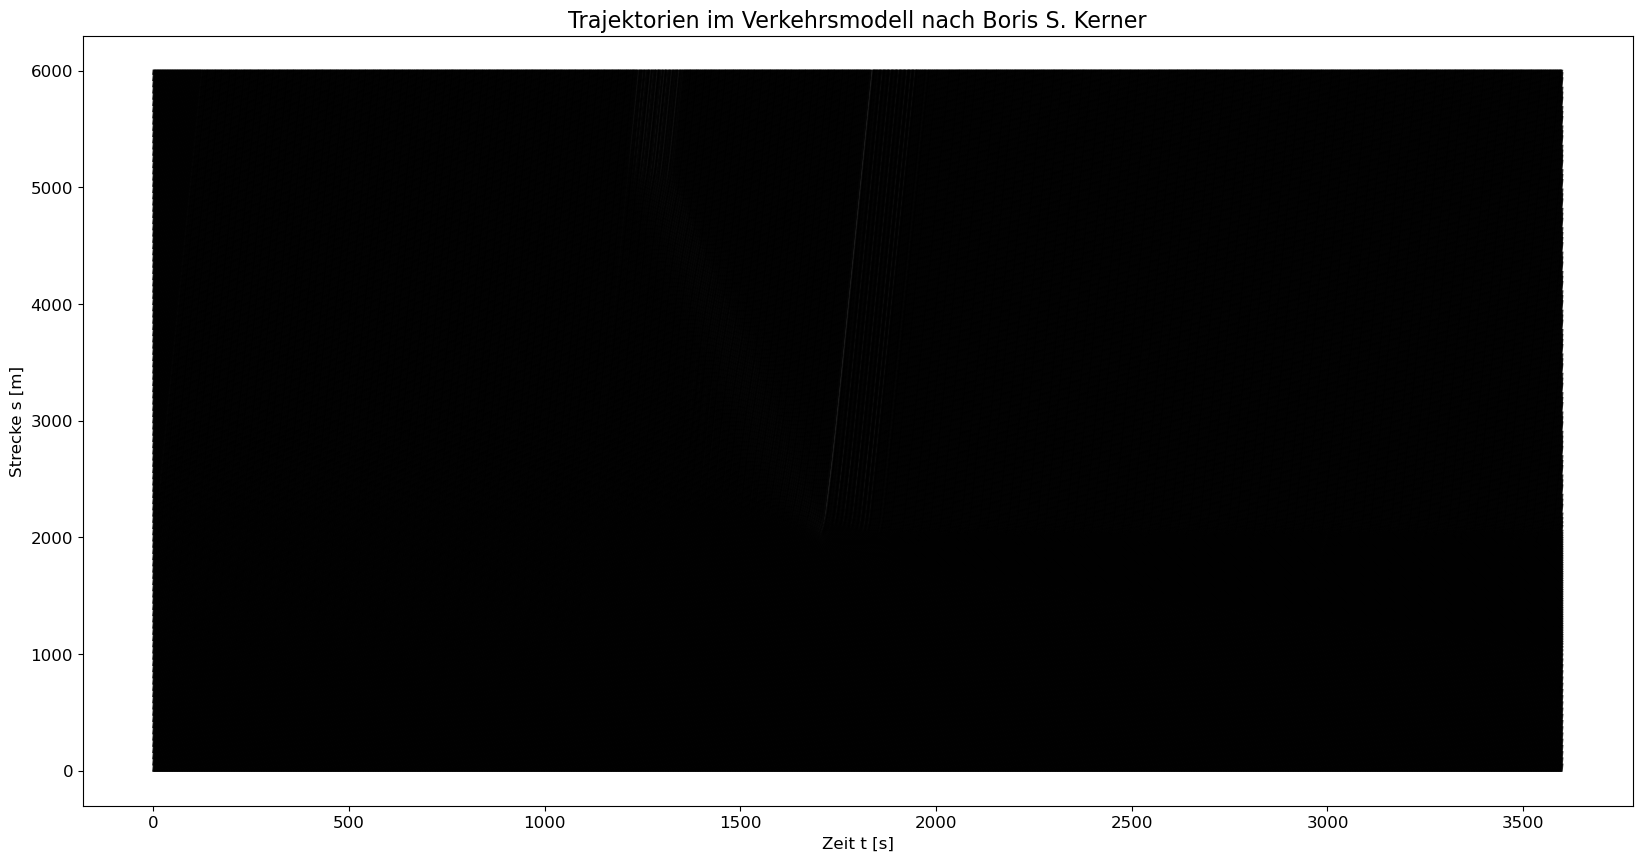

In [9]:
Startzeit = now()
println("Startzeit = $Startzeit")

figure(figsize=(20,10))
#
#for i in movement_Index_numbers
#    plot(movement_vec[i][2] , movement_vec[i][3], color="k")
#end

for i in movement_Index_numbers # 1:1
    plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="k", alpha=0.8)
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Strecke s [m]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
#xlim([100, 300])
#ylim([7000, 8000])
#xlim([110, 300])
#ylim([1000, 2500])
#legend()
title("Trajektorien im Verkehrsmodell nach Boris S. Kerner",fontsize=16)
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Trajektorien 1.svg", bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

Startzeit = 2024-08-24T13:02:52.181
Endzeit   = 2024-08-24T13:05:24.367


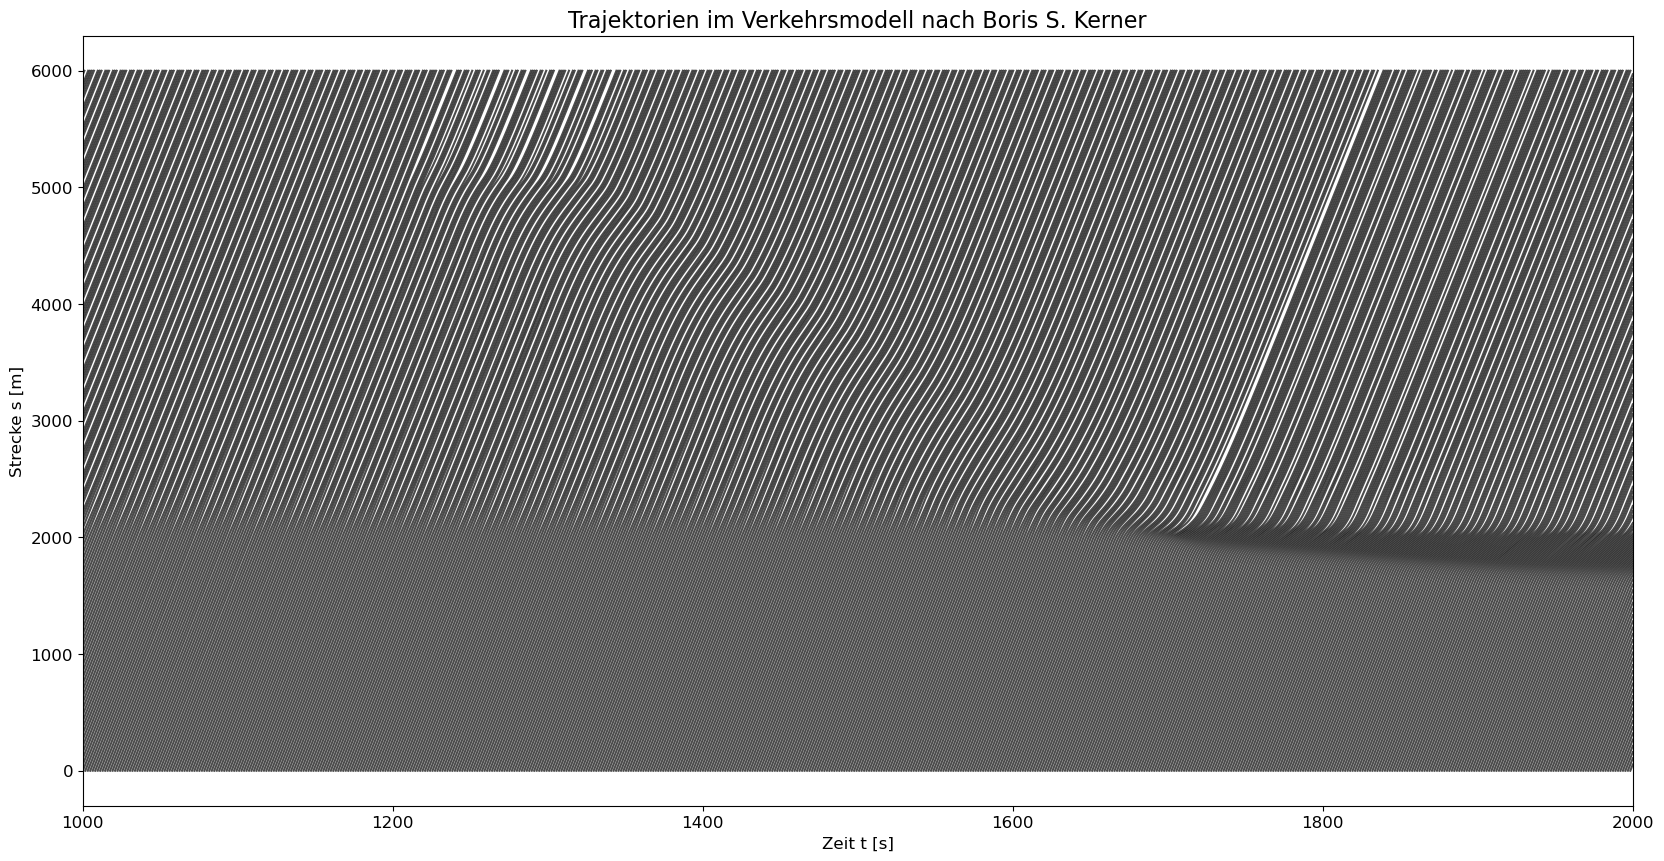

In [10]:
Startzeit = now()
println("Startzeit = $Startzeit")

figure(figsize=(20,10))

for i in movement_Index_numbers # 1:1
    plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="k", alpha=0.7)
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Strecke s [m]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
xlim([1000, 2000])
#ylim([1500, 3500])
#legend()
title("Trajektorien im Verkehrsmodell nach Boris S. Kerner",fontsize=16)
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Trajektorien 1.svg", bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

Startzeit = 2024-08-24T13:05:27.635
Endzeit   = 2024-08-24T13:07:22.886


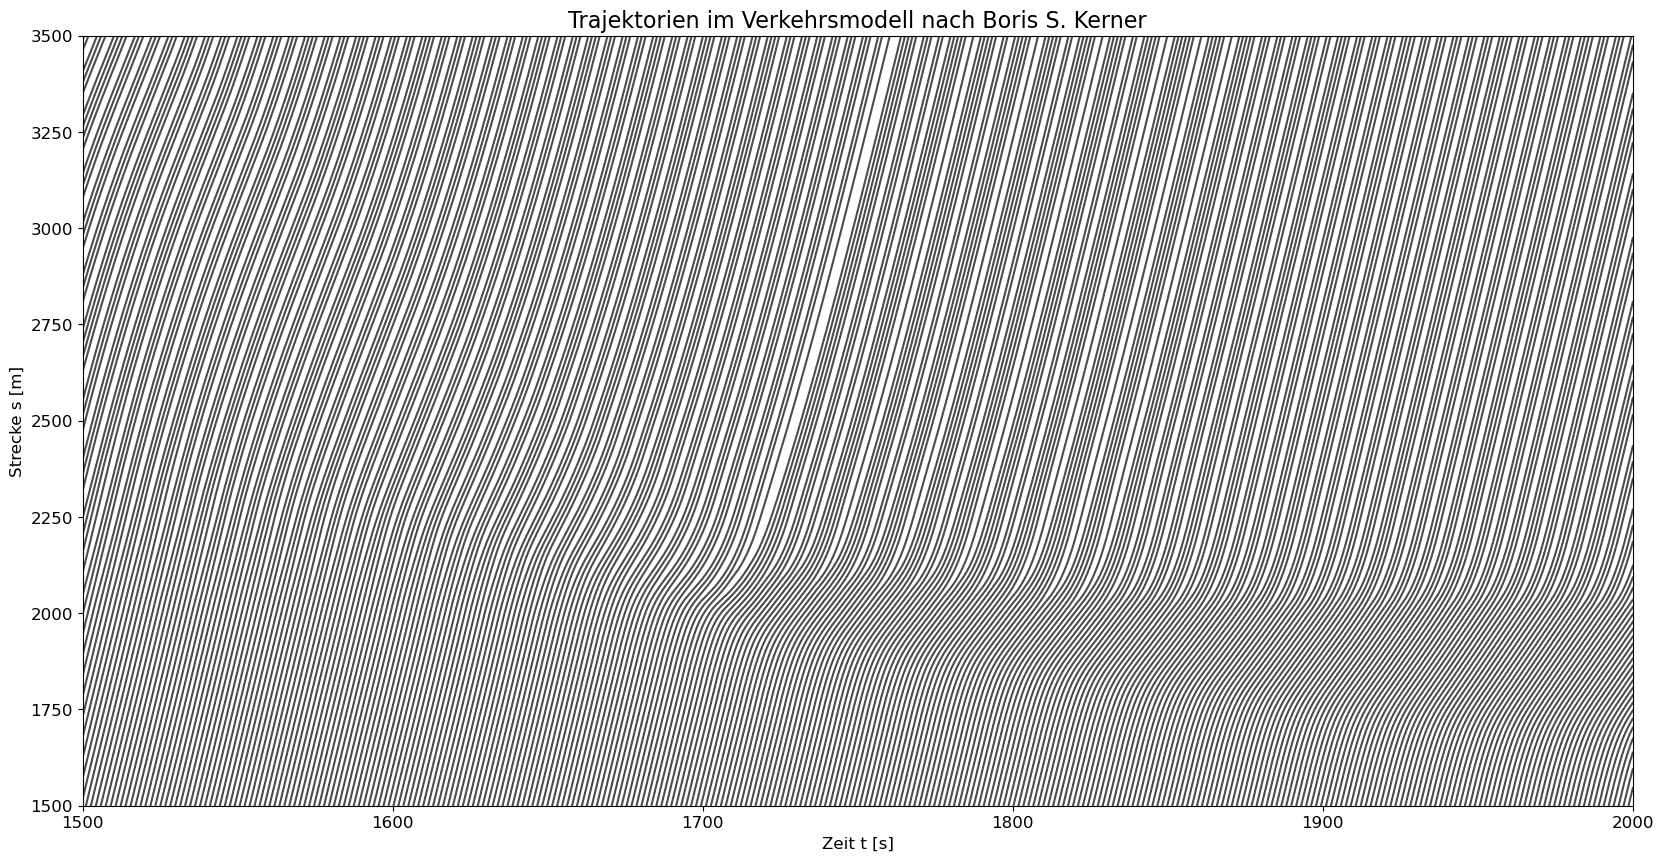

In [11]:
Startzeit = now()
println("Startzeit = $Startzeit")

figure(figsize=(20,10))

for i in movement_Index_numbers # 1:1
    plot(movement_vec[i][1] , movement_vec[i][2] , label="$i", color="k", alpha=0.7)
end

xlabel("Zeit t [s]", loc="center",fontsize=12)
ylabel("Strecke s [m]",fontsize=12)

xticks(fontsize=12)  # Größe der x-Achsen-Ticklabels
yticks(fontsize=12)  # Größe der y-Achsen-Ticklabels
xlim([1500, 2000])
ylim([1500, 3500])
#legend()
title("Trajektorien im Verkehrsmodell nach Boris S. Kerner",fontsize=16)
#savefig("C:/Users/Fliese/Desktop/Master-Arbeit/Kerner-Modell/Bilder/Trajektorien 1.svg", bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

# Besetzung der Fahrbahn

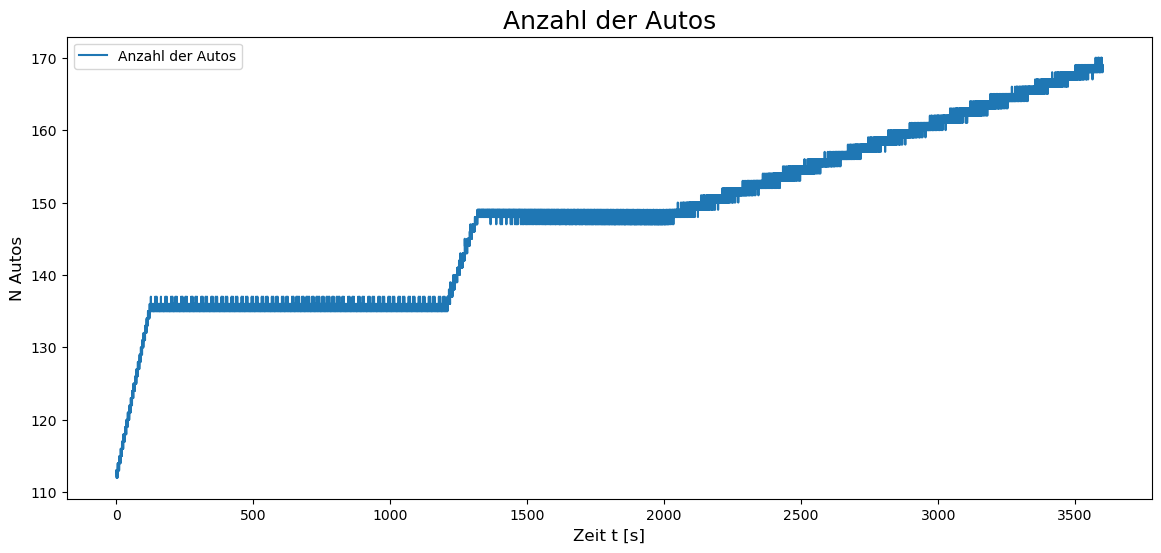

PyObject Text(24.999999999999993, 0.5, 'N Autos')

In [12]:
cars_on_trak_vals = []
for t_ArIndex in 1:length(t_vec_export)
    len = length(s_vec_export[t_ArIndex])
    push!(cars_on_trak_vals, len)
end
figure(figsize=(14,6))
plot(t_vec_export , cars_on_trak_vals, label="Anzahl der Autos")
legend()
title("Anzahl der Autos", fontsize=18)
xlabel("Zeit t [s]", fontsize=12)
ylabel("N Autos", fontsize=12)

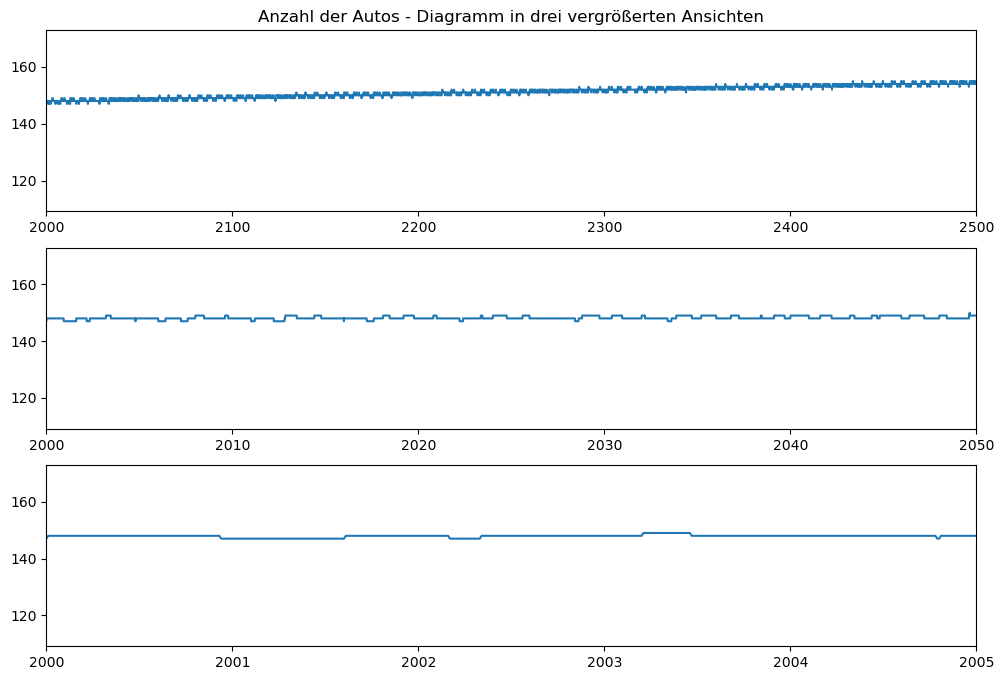

(2000.0, 2005.0)

In [13]:
start, dist1 , dist2 , dist3 = 2000 , 500 , 50 , 5
# Subplots erstellen
fig, axs = subplots(3, 1, figsize=(12, 8))  # 3 Zeilen, 1 Spalte

axs[1].plot(t_vec_export , cars_on_trak_vals)
axs[1].set_xlim([start, start + dist1]) #2000 bis 2500
axs[1].set_title("Anzahl der Autos - Diagramm in drei vergrößerten Ansichten")

axs[2].plot(t_vec_export , cars_on_trak_vals)
axs[2].set_xlim([start, start + dist2]) #2000 bis 2050
axs[3].plot(t_vec_export , cars_on_trak_vals)
axs[3].set_xlim([start, start + dist3]) #2000 bis 2005

# v-t-Diagramme - verschiedene Ansichten

## v-t-Diagramme - Version 2

In [14]:
# Diese Funktion erzeugt einen Teilarray aus einem bereits bestehenden Array um einen zentralen Index pos
function make_array_from_array(Array , pos , pos_range)
    exp_array = []
    for i in (pos - pos_range) : (pos + pos_range)
        push!(exp_array , Array[i])
    end
    return exp_array
end

make_array_from_array (generic function with 1 method)

In [16]:
Startzeit = now()
println("Startzeit = $Startzeit")

speed_at_loc_5d7km       = []
speed_at_loc_6d0km       = []
speed_at_loc_7d0km       = []
Ortsindex_at_loc_5d7km   = 0
Ortsindex_at_loc_6d0km   = 0
Ortsindex_at_loc_7d0km   = 0
#Ortsindices_at_loc_5d7km = [] ; #Ortsindices_at_loc_7d0km = []
mean5d7 = 0
mean7d0 = 0
mean7d0 = 0
create_mean5d7_array = []
create_mean6d0_array = []
create_mean7d0_array = []

posrange = 5

loc_5d7km = 1700 #5700
loc_6d0km = 2000 #6000
loc_7d0km = 3000 #7000

# Für den Fehlerreport
problematische_Indizes_5d7 = []
problematische_Indizes_6d0 = []
problematische_Indizes_7d0 = []


#Progressmeter 1
h100percent = length(t_vec_export) ; println("h100percent = $h100percent")
progress1_param1 = 0
progress1_param2 = 0
        

for t_ArIndex in 1:length(t_vec_export) # 10000
    Ortsindex_at_loc_5d7km = argmin(abs.(s_vec_export[t_ArIndex] .- loc_5d7km))
    # Index mit dem kleinsten Wert ausgeben lassen
    Ortsindex_at_loc_6d0km = argmin(abs.(s_vec_export[t_ArIndex] .- loc_6d0km))
    Ortsindex_at_loc_7d0km = argmin(abs.(s_vec_export[t_ArIndex] .- loc_7d0km))
    
    create_mean5d7_array = make_array_from_array(v_vec_export[t_ArIndex] , Ortsindex_at_loc_5d7km , posrange)
    create_mean6d0_array = make_array_from_array(v_vec_export[t_ArIndex] , Ortsindex_at_loc_6d0km , posrange)
    create_mean7d0_array = make_array_from_array(v_vec_export[t_ArIndex] , Ortsindex_at_loc_7d0km , posrange)

    # create_mean5d7_array
    if length(create_mean5d7_array) == 1 + 2 * posrange
        mean5d7 = sum(create_mean5d7_array) / length(create_mean5d7_array)
    else
        mean5d7 = v_vec_export[t_ArIndex][Ortsindex_at_loc_5d7km]
        push!(problematische_Indizes_5d7, t_ArIndex)
    end
    # create_mean6d0_array
    if length(create_mean6d0_array) == 1 + 2 * posrange
        mean6d0 = sum(create_mean6d0_array) / length(create_mean6d0_array)
    else
        mean6d0 = v_vec_export[t_ArIndex][Ortsindex_at_loc_6d0km]
        push!(problematische_Indizes_6d0, t_ArIndex)
    end
    # create_mean7d0_array
    if length(create_mean7d0_array) == 1 + 2 * posrange
        mean7d0 = sum(create_mean7d0_array) / length(create_mean7d0_array)
    else
        mean7d0 = v_vec_export[t_ArIndex][Ortsindex_at_loc_7d0km]
        push!(problematische_Indizes_7d0, t_ArIndex)
    end
    push!(speed_at_loc_5d7km , mean5d7)
    push!(speed_at_loc_6d0km , mean6d0)
    push!(speed_at_loc_7d0km , mean7d0)
    
    #Progressmeter 1
    progress1_param1 = progress1_param1 + 1/h100percent
    if progress1_param1 ≥ 0.1
        progress1_param2 = progress1_param2 + 10
        jetzt = now()
        println("$jetzt   progress = $progress1_param2 %")
        progress1_param1 = progress1_param1 - 0.1
    end
end

println("problematische_Indizes_5d7 = $problematische_Indizes_5d7")
println("problematische_Indizes_6d0 = $problematische_Indizes_6d0")
println("problematische_Indizes_7d0 = $problematische_Indizes_7d0")
Zielzeit = now()
println("Endzeit   = $Zielzeit")

Startzeit = 2024-08-24T14:21:23.316
h100percent = 360001
2024-08-24T14:21:40.552   progress = 10 %
2024-08-24T14:21:43.730   progress = 20 %
2024-08-24T14:21:47.509   progress = 30 %
2024-08-24T14:21:50.072   progress = 40 %
2024-08-24T14:21:52.750   progress = 50 %
2024-08-24T14:21:55.949   progress = 60 %
2024-08-24T14:21:58.704   progress = 70 %
2024-08-24T14:22:01.861   progress = 80 %
2024-08-24T14:22:04.463   progress = 90 %
problematische_Indizes_5d7 = Any[]
problematische_Indizes_6d0 = Any[]
problematische_Indizes_7d0 = Any[]
Endzeit   = 2024-08-24T14:22:08.250


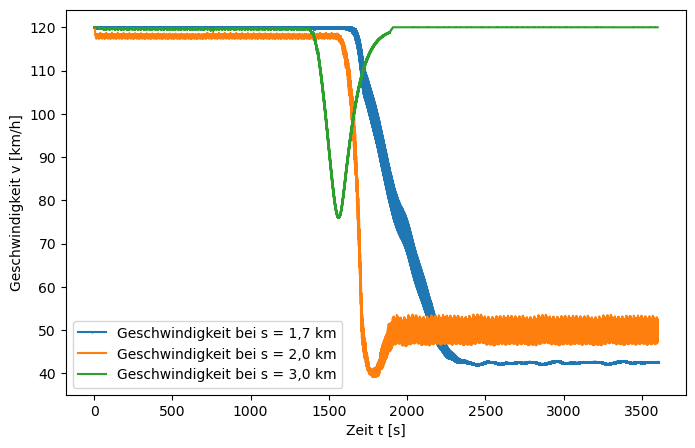

PyObject <matplotlib.legend.Legend object at 0x000001E4FB70B490>

In [17]:
figure(figsize=(8,5))
plot(t_vec_export , 3.6*speed_at_loc_5d7km , linestyle = "-",marker ="o", markersize=0.5, label="Geschwindigkeit bei s = 1,7 km")
plot(t_vec_export , 3.6*speed_at_loc_6d0km , label="Geschwindigkeit bei s = 2,0 km")
plot(t_vec_export , 3.6*speed_at_loc_7d0km , label="Geschwindigkeit bei s = 3,0 km")
#xlim([1699,1700])
xlabel("Zeit t [s]")
ylabel("Geschwindigkeit v [km/h]")
legend()

Startzeit = 2024-08-24T14:26:01.345
Endzeit   = 2024-08-24T14:26:03.273


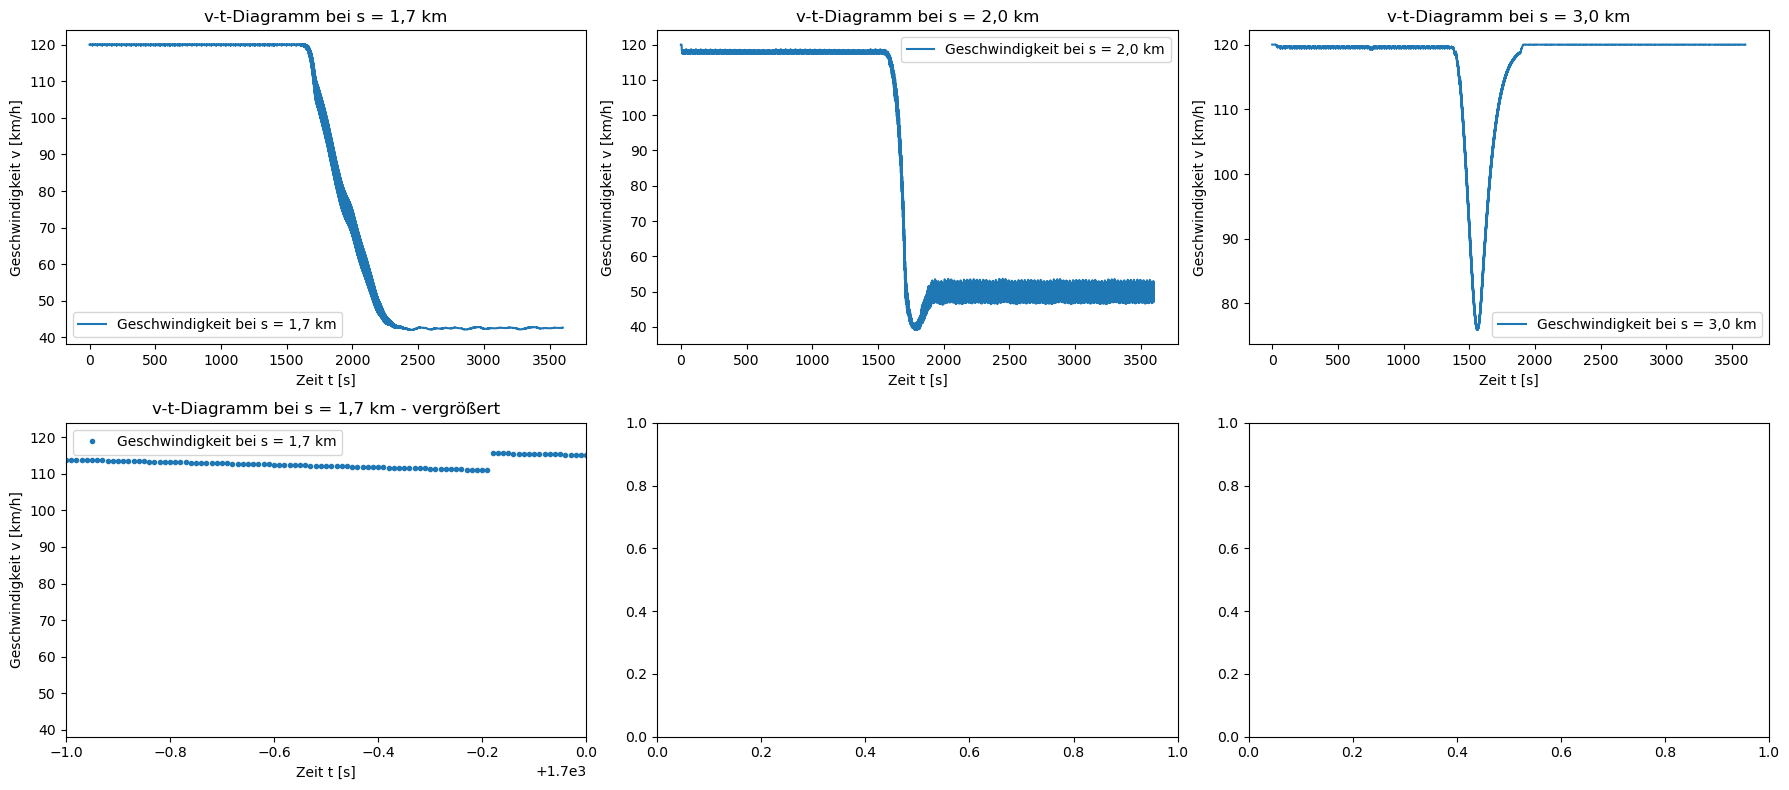

In [21]:
Startzeit = now()
println("Startzeit = $Startzeit")


# Subplots erstellen
fig, axs = subplots(2, 3, figsize=(18, 8))  # 1 Zeile, 2 Spalten

# Erster Subplot
axs[1].plot(t_vec_export , 3.6*speed_at_loc_5d7km , label="Geschwindigkeit bei s = 1,7 km")
axs[1].set_xlabel("Zeit t [s]")
axs[1].set_ylabel("Geschwindigkeit v [km/h]")
axs[1].set_title("v-t-Diagramm bei s = 1,7 km")
axs[1].legend()

# Zweiter Subplot - unten links
axs[2].plot(t_vec_export , 3.6*speed_at_loc_5d7km , ".", label="Geschwindigkeit bei s = 1,7 km")
axs[2].set_xlabel("Zeit t [s]")
axs[2].set_ylabel("Geschwindigkeit v [km/h]")
axs[2].set_xlim([1699,1700])
axs[2].set_title("v-t-Diagramm bei s = 1,7 km - vergrößert")
axs[2].legend()

# Dritter Subplot - oben mittig
axs[3].plot(t_vec_export , 3.6*speed_at_loc_6d0km , label="Geschwindigkeit bei s = 2,0 km")
axs[3].set_xlabel("Zeit t [s]")
axs[3].set_ylabel("Geschwindigkeit v [km/h]")
axs[3].set_title("v-t-Diagramm bei s = 2,0 km")
axs[3].legend()

# Fünfter Subplot - oben rechts
axs[5].plot(t_vec_export , 3.6*speed_at_loc_7d0km , label="Geschwindigkeit bei s = 3,0 km")
axs[5].set_xlabel("Zeit t [s]")
axs[5].set_ylabel("Geschwindigkeit v [km/h]")
axs[5].set_title("v-t-Diagramm bei s = 3,0 km")
axs[5].legend()


# Layout anpassen
tight_layout()

# Plot anzeigen
show()

Zielzeit = now()
println("Endzeit   = $Zielzeit")

# zeitlich gemittelte Geschwindigkeitswerte

In [22]:
Startzeit = now()
println("Startzeit = $Startzeit")


# 100 t-werte pro Sekunde => 3000 pro halbe Minute
t_pos_range   = 3000

t_range_reduced = 0
#t_range_right = 0
averaged_speed_at_loc_5d7km = []
averaged_speed_at_loc_6d0km = []
averaged_speed_at_loc_7d0km = []
temp_vec5d7 = []
temp_vec6d0 = []
temp_vec7d0 = []

#Progressmeter 1
h100percent = length(speed_at_loc_5d7km)
println("h100percent = $h100percent")
progress1_param1 = 0
progress1_param2 = 0
    

for i in 1 : length(speed_at_loc_5d7km)
    if i ≤ t_pos_range
        t_range_reduced = i - 1
        
        temp_vec5d7 = [(speed_at_loc_5d7km[j]) for j in 1:(i + t_range_reduced)]
        push!(averaged_speed_at_loc_5d7km , mean(temp_vec5d7))

        temp_vec6d0 = [(speed_at_loc_6d0km[j]) for j in 1:(i + t_range_reduced)]
        push!(averaged_speed_at_loc_6d0km , mean(temp_vec6d0))
        
        temp_vec7d0 = [(speed_at_loc_7d0km[j]) for j in 1:(i + t_range_reduced)]
        push!(averaged_speed_at_loc_7d0km , mean(temp_vec7d0))
        
    elseif t_pos_range < i ≤ (length(speed_at_loc_5d7km) - t_pos_range)
        
        temp_vec5d7 = [(speed_at_loc_5d7km[j]) for j in (i - t_range_reduced) : (i + t_range_reduced)]
        push!(averaged_speed_at_loc_5d7km , mean(temp_vec5d7))
        temp_vec6d0 = [(speed_at_loc_6d0km[j]) for j in (i - t_range_reduced) : (i + t_range_reduced)]
        push!(averaged_speed_at_loc_6d0km , mean(temp_vec6d0))
        temp_vec7d0 = [(speed_at_loc_7d0km[j]) for j in (i - t_range_reduced) : (i + t_range_reduced)]
        push!(averaged_speed_at_loc_7d0km , mean(temp_vec7d0))
        
    elseif (length(speed_at_loc_5d7km) - t_pos_range) < i
        
        temp_vec5d7 = [(speed_at_loc_5d7km[j]) for j in (i - t_range_reduced) : length(speed_at_loc_5d7km)]
        push!(averaged_speed_at_loc_5d7km , mean(temp_vec5d7))
        temp_vec6d0 = [(speed_at_loc_6d0km[j]) for j in (i - t_range_reduced) : length(speed_at_loc_5d7km)]
        push!(averaged_speed_at_loc_6d0km , mean(temp_vec6d0))
        temp_vec7d0 = [(speed_at_loc_7d0km[j]) for j in (i - t_range_reduced) : length(speed_at_loc_5d7km)]
        push!(averaged_speed_at_loc_7d0km , mean(temp_vec7d0))
        
    end
    
    #Progressmeter 1
    progress1_param1 = progress1_param1 + 1/h100percent
    if progress1_param1 ≥ 0.1
        progress1_param2 = progress1_param2 + 10
        jetzt = now()
        println("$jetzt   progress = $progress1_param2 %")
        progress1_param1 = progress1_param1 - 0.1
    end
end

Zielzeit = now()
println("Endzeit   = $Zielzeit")

Startzeit = 2024-08-24T14:28:28.019
h100percent = 360001
2024-08-24T14:29:17.525   progress = 10 %
2024-08-24T14:30:09.064   progress = 20 %
2024-08-24T14:30:54.553   progress = 30 %
2024-08-24T14:31:41.318   progress = 40 %
2024-08-24T14:32:32.131   progress = 50 %
2024-08-24T14:33:17.934   progress = 60 %
2024-08-24T14:34:02.192   progress = 70 %
2024-08-24T14:34:53.303   progress = 80 %
2024-08-24T14:35:39.145   progress = 90 %
Endzeit   = 2024-08-24T14:36:28.033


Startzeit = 2024-08-24T14:47:18.596
Endzeit   = 2024-08-24T14:47:19.385


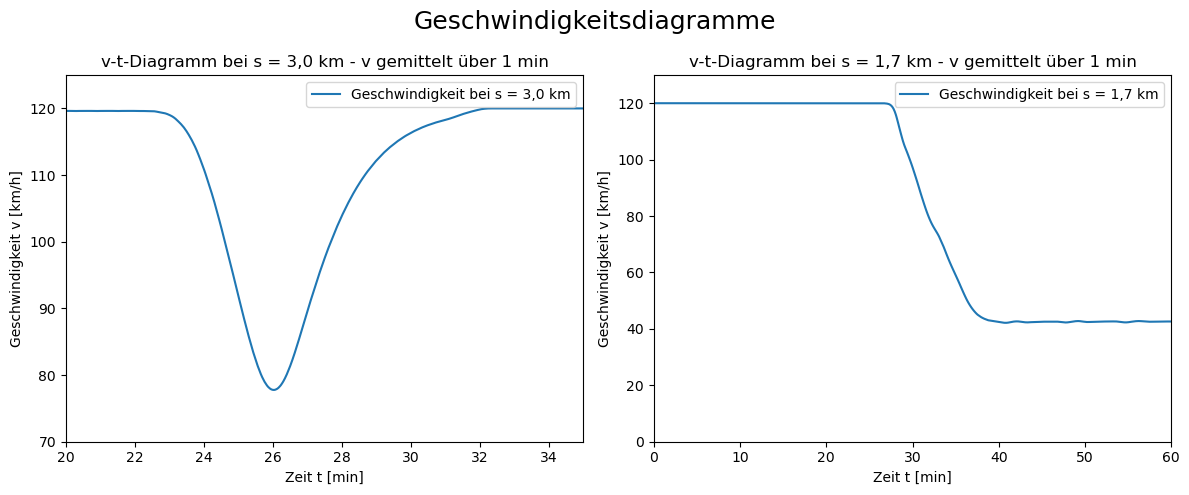

In [23]:
Startzeit = now()
println("Startzeit = $Startzeit")

# Subplots erstellen
fig, axs = subplots(1, 2, figsize=(12, 5))  # 1 Zeile, 2 Spalten

# Erster Subplot
axs[1].plot(t_vec_export/60 , 3.6*averaged_speed_at_loc_7d0km , label="Geschwindigkeit bei s = 3,0 km")
axs[1].set_xlabel("Zeit t [min]")
axs[1].set_ylabel("Geschwindigkeit v [km/h]")
axs[1].set_xlim([20, 35])
axs[1].set_ylim([70, 125])
axs[1].set_title("v-t-Diagramm bei s = 3,0 km - v gemittelt über 1 min")
axs[1].legend()

# Zweiter Subplot
axs[2].plot(t_vec_export/60 , 3.6*averaged_speed_at_loc_5d7km , label="Geschwindigkeit bei s = 1,7 km")
axs[2].set_xlabel("Zeit t [min]")
axs[2].set_ylabel("Geschwindigkeit v [km/h]")
axs[2].set_xlim([0, 60])
axs[2].set_ylim([0, 130])
axs[2].set_title("v-t-Diagramm bei s = 1,7 km - v gemittelt über 1 min")
axs[2].legend()

# Layout anpassen
tight_layout()
suptitle("Geschwindigkeitsdiagramme", fontsize = 18)
subplots_adjust(top=0.85) # beeinflusst den Abstand zwischen suptitle und Subplots

#show() # Plot anzeigen

#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/v-t-Diagramme.svg",bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/v-t-Diagramme.png",bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

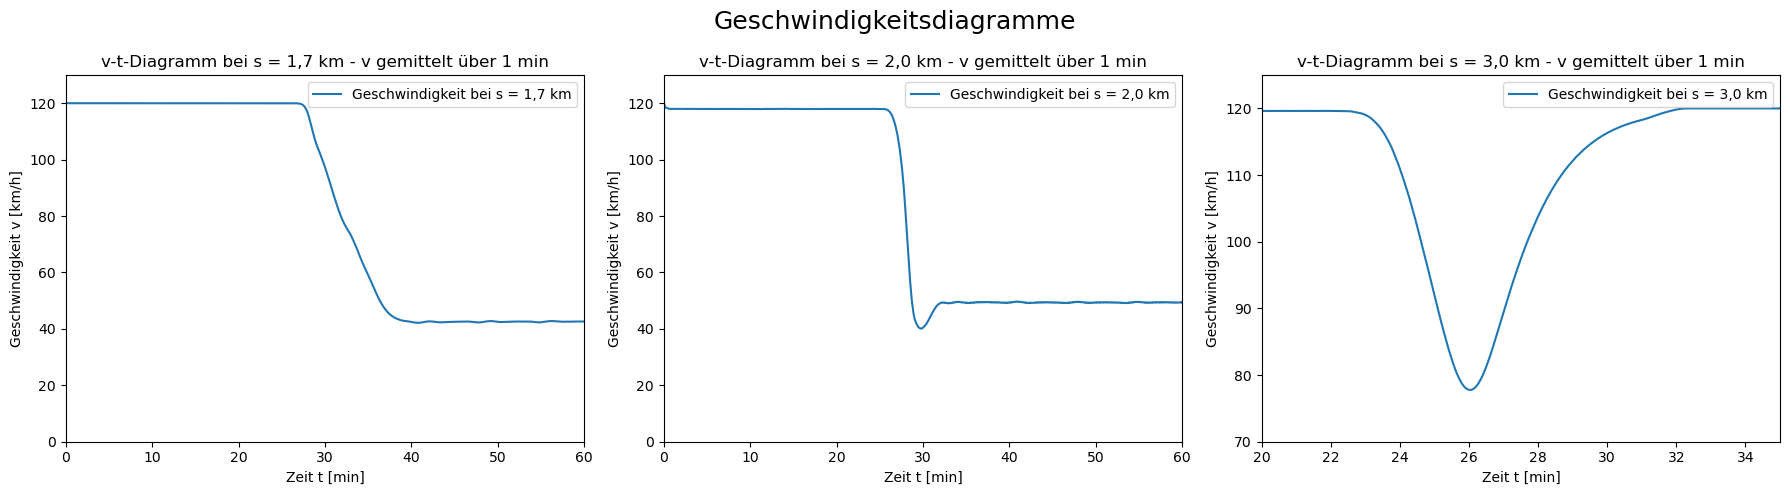

In [34]:
# Subplots erstellen
fig, axs = subplots(1, 3, figsize=(18, 5))  # 1 Zeile, 2 Spalten

# Erster Subplot
axs[1].plot(t_vec_export/60 , 3.6*averaged_speed_at_loc_5d7km , label="Geschwindigkeit bei s = 1,7 km")
axs[1].set_xlabel("Zeit t [min]")
axs[1].set_ylabel("Geschwindigkeit v [km/h]")
axs[1].set_xlim([0, 60])
axs[1].set_ylim([0, 130])
axs[1].set_title("v-t-Diagramm bei s = 1,7 km - v gemittelt über 1 min")
axs[1].legend()

# Zweiter Subplot
axs[2].plot(t_vec_export/60 , 3.6*averaged_speed_at_loc_6d0km , label="Geschwindigkeit bei s = 2,0 km")
axs[2].set_xlabel("Zeit t [min]")
axs[2].set_ylabel("Geschwindigkeit v [km/h]")
axs[2].set_xlim([0, 60])
axs[2].set_ylim([0, 130])
axs[2].set_title("v-t-Diagramm bei s = 2,0 km - v gemittelt über 1 min")
axs[2].legend()

# Dritter Subplot
axs[3].plot(t_vec_export/60 , 3.6*averaged_speed_at_loc_7d0km , label="Geschwindigkeit bei s = 3,0 km")
axs[3].set_xlabel("Zeit t [min]")
axs[3].set_ylabel("Geschwindigkeit v [km/h]")
axs[3].set_xlim([20, 35])
axs[3].set_ylim([70, 125])
axs[3].set_title("v-t-Diagramm bei s = 3,0 km - v gemittelt über 1 min")
axs[3].legend()

# Layout anpassen
tight_layout()
suptitle("Geschwindigkeitsdiagramme", fontsize = 18)
subplots_adjust(top=0.85) # beeinflusst den Abstand zwischen suptitle und Subplots

#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/v-t-Diagramme2.svg",bbox_inches="tight")
savefig("./v-t-Diagramme2.svg",bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/v-t-Diagramme2.png",bbox_inches="tight")

Startzeit = 2024-08-24T14:49:46.846
Endzeit   = 2024-08-24T14:49:48.116


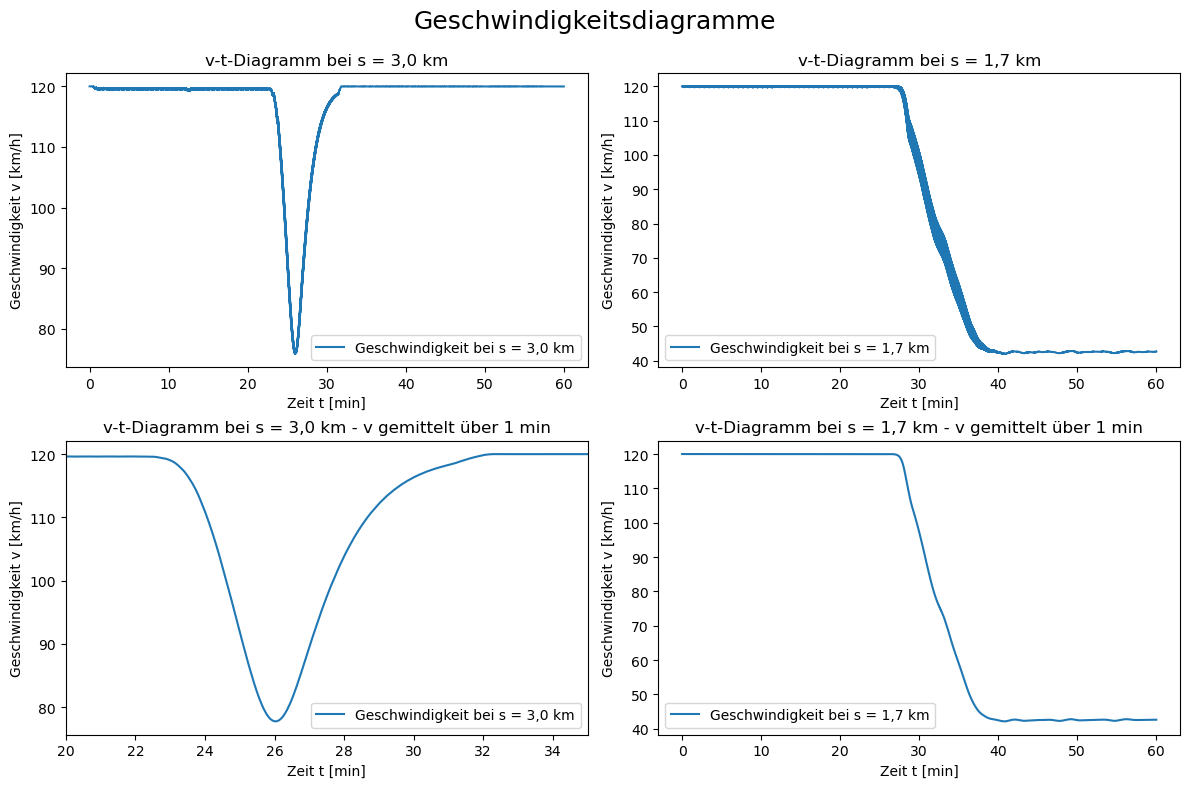

In [25]:
Startzeit = now()
println("Startzeit = $Startzeit")


# Subplots erstellen
fig, axs = subplots(2, 2, figsize=(12, 8))  # 1 Zeile, 2 Spalten

# Erster Subplot
axs[3].plot(t_vec_export/60 , 3.6*speed_at_loc_5d7km , label="Geschwindigkeit bei s = 1,7 km")
axs[3].set_xlabel("Zeit t [min]")
axs[3].set_ylabel("Geschwindigkeit v [km/h]")
axs[3].set_title("v-t-Diagramm bei s = 1,7 km")
axs[3].legend()

# Zweiter Subplot
axs[1].plot(t_vec_export/60 , 3.6*speed_at_loc_7d0km , label="Geschwindigkeit bei s = 3,0 km")
axs[1].set_xlabel("Zeit t [min]")
axs[1].set_ylabel("Geschwindigkeit v [km/h]")
axs[1].set_title("v-t-Diagramm bei s = 3,0 km")
axs[1].legend()

# Erster Subplot
axs[4].plot(t_vec_export/60 , 3.6*averaged_speed_at_loc_5d7km , label="Geschwindigkeit bei s = 1,7 km")
axs[4].set_xlabel("Zeit t [min]")
axs[4].set_ylabel("Geschwindigkeit v [km/h]")
axs[4].set_title("v-t-Diagramm bei s = 1,7 km - v gemittelt über 1 min")
axs[4].legend()

# Zweiter Subplot
axs[2].plot(t_vec_export/60 , 3.6*averaged_speed_at_loc_7d0km , label="Geschwindigkeit bei s = 3,0 km")
axs[2].set_xlabel("Zeit t [min]")
axs[2].set_ylabel("Geschwindigkeit v [km/h]")
axs[2].set_xlim([20,35])
axs[2].set_title("v-t-Diagramm bei s = 3,0 km - v gemittelt über 1 min")
axs[2].legend()

# Layout anpassen
tight_layout()
suptitle("Geschwindigkeitsdiagramme", fontsize = 18)
subplots_adjust(top=0.9) # beeinflusst den Abstand zwischen suptitle und Subplots

#show() # Plot anzeigen

#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Geschwindigkeitsdiagramme.svg",bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Geschwindigkeitsdiagramme.png",bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

# v gegen s geplottet bei t = 10 min

time_Index = 60001


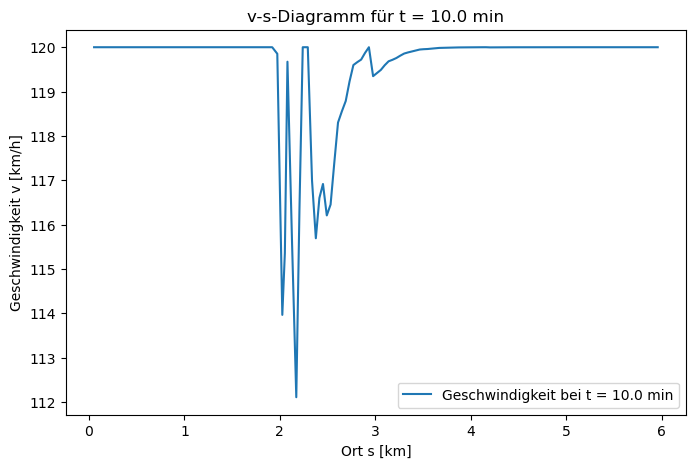

In [31]:
figure(figsize=(8,5))
time_min   = 10.0
time_Index = Int(time_min * 60 * 100 + 1)

plot(s_vec_export[time_Index]/1000 , v_vec_export[time_Index]*3.6 , label="Geschwindigkeit bei t = $time_min min")#, marker = ".")
#xlim([1699,1700])
xlabel("Ort s [km]")
ylabel("Geschwindigkeit v [km/h]")
title("v-s-Diagramm für t = $time_min min")
legend()
println("time_Index = $time_Index")

In [23]:
mod(5,3)

2

# v gemittelt über kurze Streckenabschnitte

s_step = 10.0 [Einheit ist m]

Startzeit = 2024-08-24T14:51:33.355
Endzeit   = 2024-08-24T14:51:34.934


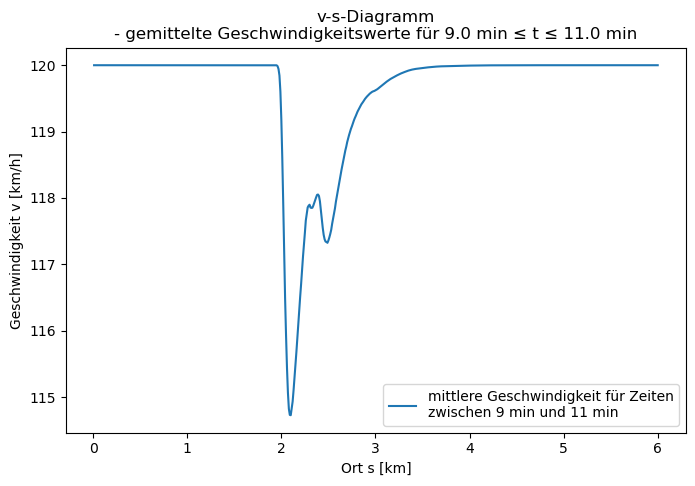

In [32]:
t_observation_begin       = 9.0 # 0 # in Minuten
t_observation_begin_Index = Int(round(t_observation_begin * 60 / t_step_input + 1))
t_observation_end         = 11.0 # 20 # in Minuten
t_observation_end_Index   = Int(round(t_observation_end * 60 / t_step_input + 1))

n_s_step_s           = 600 #600
s_step               = L_input/n_s_step_s                 ; println("s_step = $s_step [Einheit ist m]\n")
s_plot_vec           = collect(s_step : s_step : L_input)
v_on_s_plot_vec_temp = [[] for i in 1:n_s_step_s]
v_on_s_plot_vec      = [[] for i in 1:n_s_step_s]

Rest = 0

Startzeit = now()
println("Startzeit = $Startzeit")

for t_ArIndex in t_observation_begin_Index : t_observation_end_Index
    for Ortsindex in 1 : length(s_vec_export[t_ArIndex])
        location     = s_vec_export[t_ArIndex][Ortsindex]
        Rest         = mod(location , s_step)
        s_step_Index = Int((location - Rest)/s_step + 1)
        velocity     = v_vec_export[t_ArIndex][Ortsindex]
        
        push!(v_on_s_plot_vec_temp[s_step_Index] , velocity)
    end
end
#println(length(v_on_s_plot_vec_temp))
for s_step_Index in 1:n_s_step_s
    moep = mean(v_on_s_plot_vec_temp[s_step_Index])
    push!(v_on_s_plot_vec[s_step_Index], moep)
end

########################################################################
### Plot 1
########################################################################
figure(figsize=(8,5))

Startzeit_der_Beob = Int(t_observation_begin)
Endzeit_der_Beob   = Int(t_observation_end)

plot(s_plot_vec/1000 , v_on_s_plot_vec*3.6 ,
    label="mittlere Geschwindigkeit für Zeiten\nzwischen $Startzeit_der_Beob min und $Endzeit_der_Beob min")
#xlim([1699,1700])
xlabel("Ort s [km]")
ylabel("Geschwindigkeit v [km/h]")
title("v-s-Diagramm\n- gemittelte Geschwindigkeitswerte für $t_observation_begin min ≤ t ≤ $t_observation_end min")
legend()

#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/vs-Diagramm.svg",bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/vs-Diagramm.png",bbox_inches="tight")

Zielzeit = now()
println("Endzeit   = $Zielzeit")

# gleicher Plot mit Güteprüfung

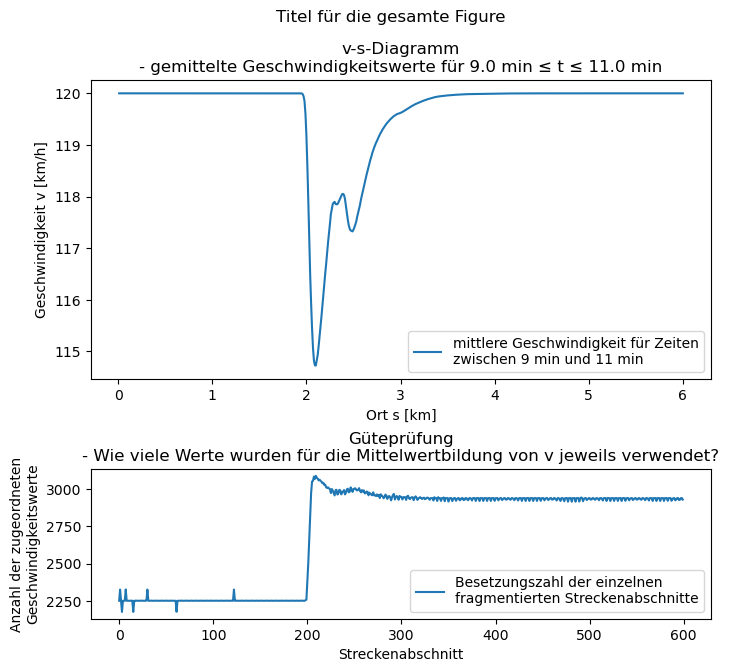

PyObject Text(0.5, 0.98, 'Titel für die gesamte Figure')

In [25]:
########################################################################
### Plot 2
########################################################################

elements_in_pos_of_v_on_s_plot_vec_temp = [(length(v_on_s_plot_vec_temp[i])) for i in 1:length(v_on_s_plot_vec_temp)]

# Subplots erstellen
fig, axs = subplots(2, 1, figsize=(8, 7),
    #sharex=true,
    gridspec_kw=Dict("height_ratios"=>[2, 1]))  # Zeilen, Spalten

Startzeit_der_Beob = Int(t_observation_begin)
Endzeit_der_Beob   = Int(t_observation_end)

# Erster Subplot
axs[1].plot(s_plot_vec/1000 , v_on_s_plot_vec*3.6 ,
    label="mittlere Geschwindigkeit für Zeiten\nzwischen $Startzeit_der_Beob min und $Endzeit_der_Beob min")
axs[1].set_xlabel("Ort s [km]")
axs[1].set_ylabel("Geschwindigkeit v [km/h]")
axs[1].set_title(
    "v-s-Diagramm\n- gemittelte Geschwindigkeitswerte für $t_observation_begin min ≤ t ≤ $t_observation_end min")
axs[1].legend()


# Zweiter Subplot
axs[2].plot(elements_in_pos_of_v_on_s_plot_vec_temp,
    label="Besetzungszahl der einzelnen\nfragmentierten Streckenabschnitte")

axs[2].set_xlabel("Streckenabschnitt")
axs[2].set_ylabel("Anzahl der zugeordneten\nGeschwindigkeitswerte")
axs[2].set_title(
    "Güteprüfung\n- Wie viele Werte wurden für die Mittelwertbildung von v jeweils verwendet?")
axs[2].legend()

# Höhenverhältnisse und Abstände anpassen
subplots_adjust(hspace=0.4)  # Ändere hspace nach Bedarf

# Titel für die gesamte Figur
suptitle("Titel für die gesamte Figure")

#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/vs-DiagrammGuete.svg",bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/vs-DiagrammGuete.png",bbox_inches="tight")

In [26]:
n_s_step_s , L_input

(600, 6000)

# Color-Plot - Geschwindigsverteilung im s-t-Feld

In [1]:
length(t_vec_export)

LoadError: UndefVarError: `t_vec_export` not defined

## Messdaten reduzieren - für 1 h gibt es 0,36 Mio Zeit-Datenpunkte

In [32]:
Startzeit = now()
println("Startzeit    = $Startzeit")

reduction_param = 100

t_vec_red = []
s_vec_red = []
v_vec_red = []

#Progressmeter 1
h100percent = length(t_vec_export)
progress1_param1 = 0
progress1_param2 = 0

for i in 1:length(t_vec_export)
    if mod(i-1, reduction_param) == 0
        push!(t_vec_red , t_vec_export[i]/60)
        push!(s_vec_red , s_vec_export[i]/1000)
        push!(v_vec_red , v_vec_export[i]*3.6)
    end
    #Progressmeter 1
    progress1_param1 = progress1_param1 + 1/h100percent
    if progress1_param1 ≥ 0.1
        progress1_param2 = progress1_param2 + 10
        println("progress1 = $progress1_param2 %")
        progress1_param1 = progress1_param1 - 0.1
    end
end

Zwischenzeit = now()
println("Zwischenzeit = $Zwischenzeit")



Startzeit    = 2024-01-15T13:19:35.267
progress1 = 10 %
progress1 = 20 %
progress1 = 30 %
progress1 = 40 %
progress1 = 50 %
progress1 = 60 %
progress1 = 70 %
progress1 = 80 %
progress1 = 90 %
Zwischenzeit = 2024-01-15T13:19:35.890


## Daten interpolieren - Eigene Interpolationsfunktionen

In [33]:
function linear_intra_extrapolation(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(2)
    y_vals = zeros(2)
    matrix_lgs = zeros(2,2)
    params_vec = zeros(2)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 1
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2]
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2]
            
        elseif 1 < s_pos_Index < (lens - 1)
            x_vals[1] = s_vec[s_pos_Index]; x_vals[2] = s_vec[s_pos_Index + 1];
            y_vals[1] = v_vec[s_pos_Index]; y_vals[2] = v_vec[s_pos_Index + 1];
                            
        elseif (lens - 1) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 1] ; x_vals[2] = s_vec[lens] ;
            y_vals[1] = v_vec[lens - 1] ; y_vals[2] = v_vec[lens] ;
            
        end
            
        for i in 1:2
            for j in 1:2
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = inv(matrix_lgs)*y_vals
        v_value_to_export = params_vec[1] + params_vec[2] * s_val
    end
    return v_value_to_export
end

linear_intra_extrapolation (generic function with 1 method)

In [34]:
function cubic_intra_extrapolation(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(4)
    y_vals = zeros(4)
    matrix_lgs = zeros(4,4)
    params_vec = zeros(4)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 2
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2] ; x_vals[3] = s_vec[3] ; x_vals[4] = s_vec[4]
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2] ; y_vals[3] = v_vec[3] ; y_vals[4] = v_vec[4]
            
        elseif 2 < s_pos_Index < (lens - 2)
            x_vals[1] = s_vec[s_pos_Index - 1]; x_vals[2] = s_vec[s_pos_Index];
            x_vals[3] = s_vec[s_pos_Index + 1]; x_vals[4] = s_vec[s_pos_Index + 2]
            
            y_vals[1] = v_vec[s_pos_Index - 1]; y_vals[2] = v_vec[s_pos_Index];
            y_vals[3] = v_vec[s_pos_Index + 1]; y_vals[4] = v_vec[s_pos_Index + 2]
                
        elseif (lens - 2) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 3] ; x_vals[2] = s_vec[lens - 2] ;
            x_vals[3] = s_vec[lens - 1] ; x_vals[4] = s_vec[lens]
            
            y_vals[1] = v_vec[lens - 3] ; y_vals[2] = v_vec[lens - 2] ;
            y_vals[3] = v_vec[lens - 1] ; y_vals[4] = v_vec[lens]
        end
            
        for i in 1:4
            for j in 1:4
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = inv(matrix_lgs)*y_vals
        v_value_to_export = params_vec[1] + params_vec[2] * s_val + params_vec[3] * s_val^2 + params_vec[4] * s_val^3
    end
    return v_value_to_export
end

cubic_intra_extrapolation (generic function with 1 method)

In [35]:
function fifth_degree_intra_extrapolation(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(6)
    y_vals = zeros(6)
    matrix_lgs = zeros(6,6)
    params_vec = zeros(6)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 4 # 4?
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2]
            x_vals[3] = s_vec[3] ; x_vals[4] = s_vec[4]
            x_vals[5] = s_vec[5] ; x_vals[6] = s_vec[6]
            
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2]
            y_vals[3] = v_vec[3] ; y_vals[4] = v_vec[4]
            y_vals[5] = v_vec[5] ; y_vals[6] = v_vec[6] 
            
        elseif 4 < s_pos_Index < (lens - 4)
            x_vals[1] = s_vec[s_pos_Index - 2] ; x_vals[2] = s_vec[s_pos_Index - 1];
            x_vals[3] = s_vec[s_pos_Index + 0] ; x_vals[4] = s_vec[s_pos_Index + 1]
            x_vals[5] = s_vec[s_pos_Index + 2] ; x_vals[6] = s_vec[s_pos_Index + 3]
            
            y_vals[1] = v_vec[s_pos_Index - 2] ; y_vals[2] = v_vec[s_pos_Index - 1];
            y_vals[3] = v_vec[s_pos_Index + 0] ; y_vals[4] = v_vec[s_pos_Index + 1]
            y_vals[5] = v_vec[s_pos_Index + 2] ; y_vals[6] = v_vec[s_pos_Index + 3]
                
        elseif (lens - 4) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 5] ; x_vals[2] = s_vec[lens - 4] ;
            x_vals[3] = s_vec[lens - 3] ; x_vals[4] = s_vec[lens - 2]
            x_vals[5] = s_vec[lens - 1] ; x_vals[6] = s_vec[lens]
            
            y_vals[1] = v_vec[lens - 5] ; y_vals[2] = v_vec[lens - 4] ;
            y_vals[3] = v_vec[lens - 3] ; y_vals[4] = v_vec[lens - 2]
            y_vals[5] = v_vec[lens - 1] ; y_vals[6] = v_vec[lens]
        end
            
        for i in 1:6
            for j in 1:6
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = inv(matrix_lgs)*y_vals
        v_value_to_export = params_vec[1] + params_vec[2] * s_val + params_vec[3] * s_val^2 + params_vec[4] * s_val^3 + params_vec[5] * s_val^4 + params_vec[6] * s_val^5
    end
    return v_value_to_export
end

fifth_degree_intra_extrapolation (generic function with 1 method)

In [36]:
function seventh_degree_intra_extrapolation(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(8)
    y_vals = zeros(8)
    matrix_lgs = zeros(8,8)
    params_vec = zeros(8)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 6 # 4?
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2]
            x_vals[3] = s_vec[3] ; x_vals[4] = s_vec[4]
            x_vals[5] = s_vec[5] ; x_vals[6] = s_vec[6]
            x_vals[7] = s_vec[7] ; x_vals[8] = s_vec[8]
            
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2]
            y_vals[3] = v_vec[3] ; y_vals[4] = v_vec[4]
            y_vals[5] = v_vec[5] ; y_vals[6] = v_vec[6]
            y_vals[7] = v_vec[7] ; y_vals[8] = v_vec[8]
            
        elseif 6 < s_pos_Index < (lens - 6)
            x_vals[1] = s_vec[s_pos_Index - 3] ; x_vals[2] = s_vec[s_pos_Index - 2]
            x_vals[3] = s_vec[s_pos_Index - 1] ; x_vals[4] = s_vec[s_pos_Index + 0]
            x_vals[5] = s_vec[s_pos_Index + 1] ; x_vals[6] = s_vec[s_pos_Index + 2]
            x_vals[7] = s_vec[s_pos_Index + 3] ; x_vals[8] = s_vec[s_pos_Index + 4]
            
            y_vals[1] = v_vec[s_pos_Index - 3] ; y_vals[2] = v_vec[s_pos_Index - 2]
            y_vals[3] = v_vec[s_pos_Index - 1] ; y_vals[4] = v_vec[s_pos_Index + 0]
            y_vals[5] = v_vec[s_pos_Index + 1] ; y_vals[6] = v_vec[s_pos_Index + 2]
            y_vals[7] = v_vec[s_pos_Index + 3] ; y_vals[8] = v_vec[s_pos_Index + 4]
                
        elseif (lens - 6) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 7] ; x_vals[2] = s_vec[lens - 6]
            x_vals[3] = s_vec[lens - 5] ; x_vals[4] = s_vec[lens - 4]
            x_vals[5] = s_vec[lens - 3] ; x_vals[6] = s_vec[lens - 2]
            x_vals[7] = s_vec[lens - 1] ; x_vals[8] = s_vec[lens]
            
            y_vals[1] = v_vec[lens - 7] ; y_vals[2] = v_vec[lens - 6]
            y_vals[3] = v_vec[lens - 5] ; y_vals[4] = v_vec[lens - 4]
            y_vals[5] = v_vec[lens - 3] ; y_vals[6] = v_vec[lens - 2]
            y_vals[7] = v_vec[lens - 1] ; y_vals[8] = v_vec[lens]
        end
            
        for i in 1:8
            for j in 1:8
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = inv(matrix_lgs)*y_vals
        v_value_to_export = (params_vec[1] + params_vec[2] * s_val + params_vec[3] * s_val^2 + params_vec[4] * s_val^3 
            + params_vec[5] * s_val^4 + params_vec[6] * s_val^5 + params_vec[7] * s_val^6 + params_vec[8] * s_val^7)
    end
    return v_value_to_export
end

seventh_degree_intra_extrapolation (generic function with 1 method)

In [37]:
# von Chat_GPT
function gauss_elimination(A_input_var, b_input_var)
    A = deepcopy(A_input_var)
    b = deepcopy(b_input_var)
    n = length(b)
    #display(hcat(A,b))

    # Vorwärtselimination
    for index_1 in 1:n
        #println("i = $i")
        # Pivotisierung (Zeilentausch), falls notwendig
        if A[index_1, index_1] == 0
            for j in (index_1+1) : n
                if !(A[index_2,index_1] == 0)
                    #exchange_index = index_2

                    a_temp        = deepcopy(A[index_2, :])
                    A[index_2, :] = A[index_1, :]
                    A[index_1, :] = a_temp
                    b_temp     = deepcopy(b[index_2])
                    b[index_2] = b[index_1]
                    b[index_1] = b_temp
                break
                end
            end
        end
        #display(hcat(A,b))

        # Skaliere die i-te Zeile, um A[i, i] gleich 1 zu setzen
        Normierungsfaktor = A[index_1, index_1]
        A[index_1, :] = A[index_1, :] / Normierungsfaktor
        b[index_1]    = b[index_1]    / Normierungsfaktor
        #display(hcat(A,b))

        # Elimination, um unter der Diagonalen Nullen zu erzeugen
        for index_2 in (index_1+1):n
            factor       = A[index_2, index_1]
            A[index_2, :] = A[index_2, :] - factor * A[index_1, :]
            b[index_2]    = b[index_2]    - factor * b[index_1]
        end
        #display(hcat(A,b))
    end
    #println("Rückwärtssubstitution")
    # Rückwärtssubstitution
    
    for Zeilen_i in 1:1:(n-1)
        for Spalten_i in (Zeilen_i+1):n
            #println("Spalten_i = $Spalten_i, Zeilen_i = $Zeilen_i")
            factor = A[Zeilen_i, Spalten_i]
            A[Zeilen_i, :] = A[Zeilen_i, :] - factor * A[Spalten_i, :]
            b[Zeilen_i]    = b[Zeilen_i]    - factor * b[Spalten_i]
            #display(hcat(A,b))
        end
    end
    #=
    for Spalten_i in n:-1:2
        for Zeilen_i in 1:Spalten_i-1
            println("Spalten_i = $Spalten_i, Zeilen_i = $Zeilen_i")
            factor = A[Zeilen_i, Spalten_i]
            A[Zeilen_i, :] = A[Zeilen_i, :] - factor * A[Spalten_i, :]
            b[Zeilen_i]    = b[Zeilen_i]    - factor * b[Spalten_i]
            display(hcat(A,b))
        end
    end
    =#
    return b
end

gauss_elimination (generic function with 1 method)

In [38]:
collect(3:-1:1)

3-element Vector{Int64}:
 3
 2
 1

In [39]:
A_in = zeros(3,3) ; b_in = zeros(3)
A_in[1,1] = 1
A_in[1,2] = 0
A_in[1,3] = 0
A_in[2,1] = 1
A_in[2,2] = 1
A_in[2,3] = 1
A_in[3,1] = 1
A_in[3,2] = 2 
A_in[3,3] = 4

b_in[1] = 3
b_in[2] = 9
b_in[3] = 25

25

In [40]:
gauss_elimination(A_in, b_in)

3-element Vector{Float64}:
 3.0
 1.0
 5.0

In [41]:
display(hcat(A_in,b_in))

3×4 Matrix{Float64}:
 1.0  0.0  0.0   3.0
 1.0  1.0  1.0   9.0
 1.0  2.0  4.0  25.0

In [42]:
# Beispielaufruf mit einer 8x8-Matrix A und einem Vektor b
A = rand(8, 8)
b = rand(8)

x = gauss_elimination(A, b)
println("Lösung x: ", x)
display(x)

Lösung x: [-3.60101583884846, -2.2443378508880922, -5.129317247398791, 5.129008688370119, 1.3998267301863008, 4.123661437190549, 3.8682318195405214, -2.523841306134487]


8-element Vector{Float64}:
 -3.60101583884846
 -2.2443378508880922
 -5.129317247398791
  5.129008688370119
  1.3998267301863008
  4.123661437190549
  3.8682318195405214
 -2.523841306134487

In [43]:
function seventh_degree_intra_extrapolation_2nd(s_vec, v_vec, s_val) #neu
    lens              = length(s_vec)
    s_pos_Index       = 0
    v_value_to_export = 0
    
    x_vals = zeros(8)
    y_vals = zeros(8)
    matrix_lgs = zeros(8,8)
    params_vec = zeros(8)
    
    if s_val < s_vec[1]
        s_pos_Index = 0
    elseif s_val ≥ s_vec[lens]
        s_pos_Index = lens
    else
        for pos_Index in 1:(lens - 1) #lens
            if s_vec[pos_Index] ≤ s_val < s_vec[pos_Index + 1]
                s_pos_Index = pos_Index
                break
            end
        end
    end
    
    if s_pos_Index ≠ 0 && s_vec[s_pos_Index] == s_val
        v_value_to_export = v_vec[s_pos_Index]
    elseif s_pos_Index == 0 || ( s_pos_Index > 0 && s_vec[s_pos_Index] < s_val)
        if s_pos_Index ≤ 6 # 4?
            x_vals[1] = s_vec[1] ; x_vals[2] = s_vec[2]
            x_vals[3] = s_vec[3] ; x_vals[4] = s_vec[4]
            x_vals[5] = s_vec[5] ; x_vals[6] = s_vec[6]
            x_vals[7] = s_vec[7] ; x_vals[8] = s_vec[8]
            
            y_vals[1] = v_vec[1] ; y_vals[2] = v_vec[2]
            y_vals[3] = v_vec[3] ; y_vals[4] = v_vec[4]
            y_vals[5] = v_vec[5] ; y_vals[6] = v_vec[6]
            y_vals[7] = v_vec[7] ; y_vals[8] = v_vec[8]
            
        elseif 6 < s_pos_Index < (lens - 6)
            x_vals[1] = s_vec[s_pos_Index - 3] ; x_vals[2] = s_vec[s_pos_Index - 2]
            x_vals[3] = s_vec[s_pos_Index - 1] ; x_vals[4] = s_vec[s_pos_Index + 0]
            x_vals[5] = s_vec[s_pos_Index + 1] ; x_vals[6] = s_vec[s_pos_Index + 2]
            x_vals[7] = s_vec[s_pos_Index + 3] ; x_vals[8] = s_vec[s_pos_Index + 4]
            
            y_vals[1] = v_vec[s_pos_Index - 3] ; y_vals[2] = v_vec[s_pos_Index - 2]
            y_vals[3] = v_vec[s_pos_Index - 1] ; y_vals[4] = v_vec[s_pos_Index + 0]
            y_vals[5] = v_vec[s_pos_Index + 1] ; y_vals[6] = v_vec[s_pos_Index + 2]
            y_vals[7] = v_vec[s_pos_Index + 3] ; y_vals[8] = v_vec[s_pos_Index + 4]
                
        elseif (lens - 6) ≤ s_pos_Index
            x_vals[1] = s_vec[lens - 7] ; x_vals[2] = s_vec[lens - 6]
            x_vals[3] = s_vec[lens - 5] ; x_vals[4] = s_vec[lens - 4]
            x_vals[5] = s_vec[lens - 3] ; x_vals[6] = s_vec[lens - 2]
            x_vals[7] = s_vec[lens - 1] ; x_vals[8] = s_vec[lens]
            
            y_vals[1] = v_vec[lens - 7] ; y_vals[2] = v_vec[lens - 6]
            y_vals[3] = v_vec[lens - 5] ; y_vals[4] = v_vec[lens - 4]
            y_vals[5] = v_vec[lens - 3] ; y_vals[6] = v_vec[lens - 2]
            y_vals[7] = v_vec[lens - 1] ; y_vals[8] = v_vec[lens]
        end
            
        for i in 1:8
            for j in 1:8
                matrix_lgs[i,j] = (x_vals[i])^(j-1)
            end
        end
        params_vec = gauss_elimination(matrix_lgs, y_vals)
        
        #inv(matrix_lgs)*y_vals
        v_value_to_export = (params_vec[1] + params_vec[2] * s_val + params_vec[3] * s_val^2 + params_vec[4] * s_val^3 
            + params_vec[5] * s_val^4 + params_vec[6] * s_val^5 + params_vec[7] * s_val^6 + params_vec[8] * s_val^7)
    end
    return v_value_to_export
end

seventh_degree_intra_extrapolation_2nd (generic function with 1 method)

## Test der Interpolationsfunktionen

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40][5, 4, 2, 5, 3, 4, 4, 2, 3, 5, 2, 4, 3, 3, 5, 5, 3, 4, 2, 3, 2, 3, 5, 2, 5, 5, 4, 5, 2, 2, 2, 2, 3, 4, 3, 4, 3, 5, 2, 5]


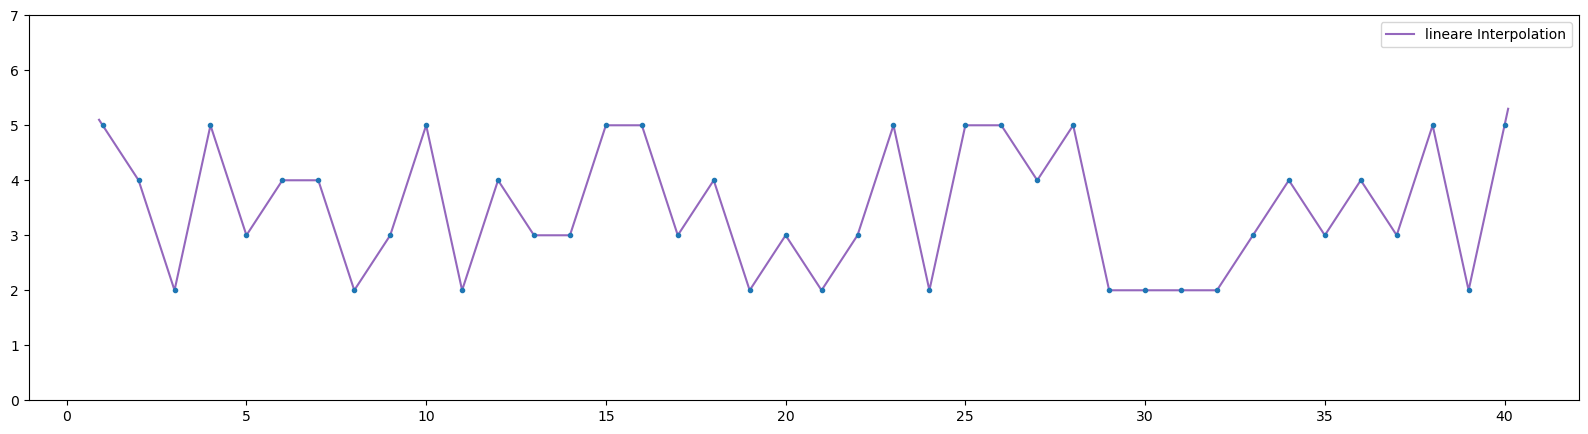

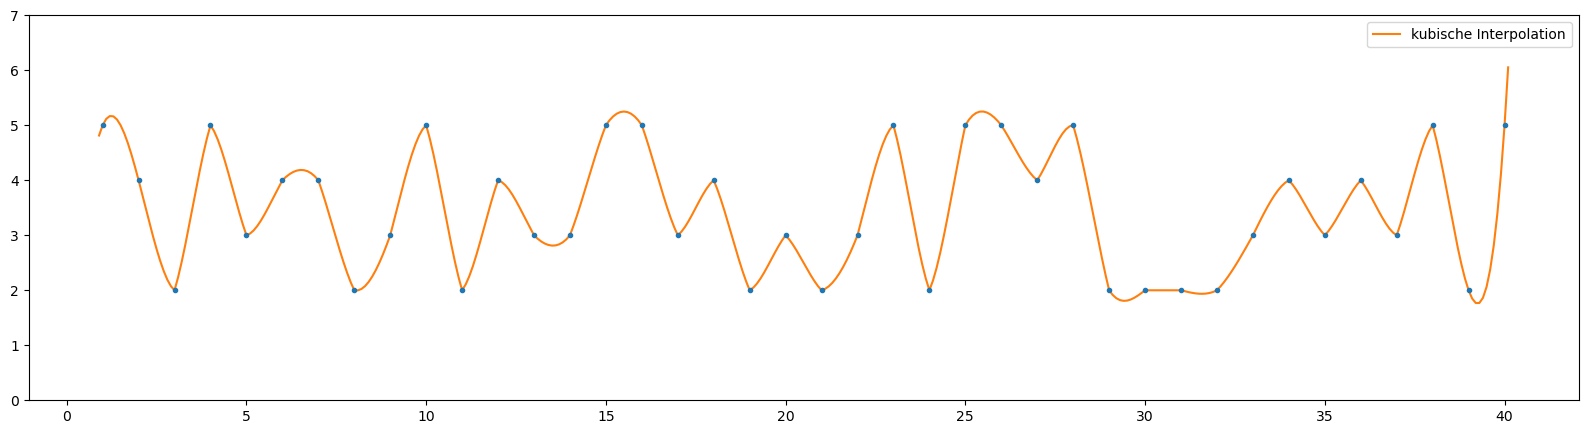

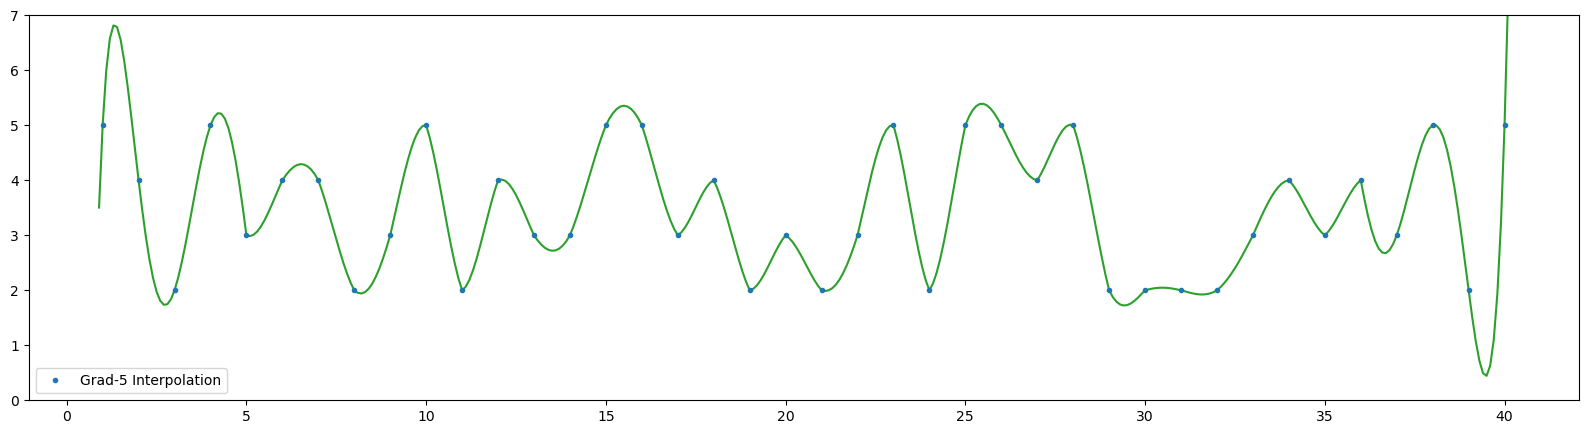

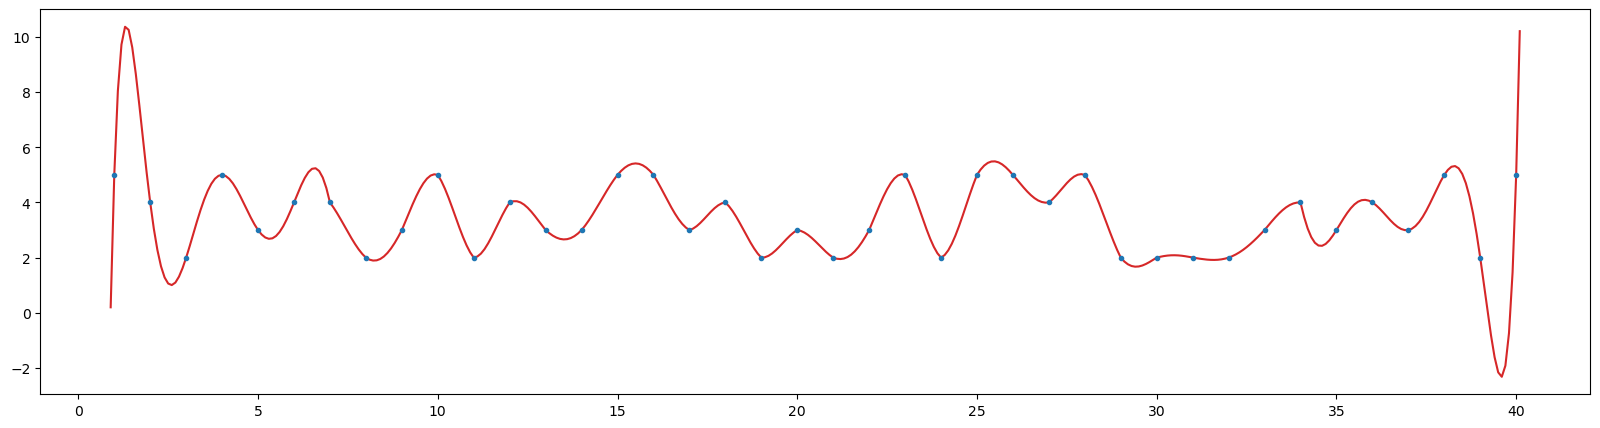

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000019570A67760>

In [44]:
# zu fittende Daten
s_begin_val = 1
s_end_val   = 40
s_vec_input = collect(s_begin_val:1:s_end_val)
v_vec_input = [rand(2:5) for _ in s_vec_input]

#v_vec_input = [4, 5, 3, 3, 4, 4, 3, 2, 3, 4]
println(s_vec_input, v_vec_input)

# Datenfit
s_plot_try_vec = collect((s_begin_val-0.1) : 0.1 : (s_end_val+0.1))
v0_plot_try_vec_int = [linear_intra_extrapolation(s_vec_input, v_vec_input, x_val) for x_val in s_plot_try_vec]
v1_plot_try_vec_int = [cubic_intra_extrapolation(s_vec_input, v_vec_input, x_val) for x_val in s_plot_try_vec]
v2_plot_try_vec_int = [fifth_degree_intra_extrapolation(s_vec_input, v_vec_input, x_val) for x_val in s_plot_try_vec]
v3_plot_try_vec_int = [seventh_degree_intra_extrapolation_2nd(s_vec_input, v_vec_input, x_val) for x_val in s_plot_try_vec]

# Plot
figure(figsize=(20,5))
plot(s_plot_try_vec , v0_plot_try_vec_int , color="tab:purple" , label="lineare Interpolation")
plot(s_vec_input , v_vec_input, "." , markersize=6.0,color="tab:blue")
ylim([0,7]) ; legend()

figure(figsize=(20,5))
plot(s_plot_try_vec , v1_plot_try_vec_int , color="tab:orange" , label="kubische Interpolation")
plot(s_vec_input , v_vec_input, "." , markersize=6.0,color="tab:blue")
ylim([0,7]) ; legend()

figure(figsize=(20,5))
plot(s_plot_try_vec , v2_plot_try_vec_int , color="tab:green")
plot(s_vec_input , v_vec_input, "." , markersize=6.0,color="tab:blue" , label="Grad-5 Interpolation")
ylim([0,7]) ; legend()

figure(figsize=(20,5))
plot(s_plot_try_vec , v3_plot_try_vec_int , color="tab:red")
plot(s_vec_input , v_vec_input, "." , markersize=6.0,color="tab:blue" , label="Grad-7 Interpolation")
#ylim([0,7]) ; legend()

## Interpolation mit eigener Interpolationsfunktion durchführen

In [48]:
Startzeit = now()
println("Startzeit = $Startzeit")

# Ortsraster, an das die v-s-Daten für jeden Zeitpunkt gefittet werden
s_vec_distanz = collect(0:0.006:6) 

# Erstellen einer Matrix für die Aufnahme der Interpolationswerte
v_interp_values = zeros(length(s_vec_distanz) , length(t_vec_red))

#Progressmeter 1
h100percent = length(t_vec_red)
println("h100percent = $h100percent")
progress1_param1 = 0
progress1_param2 = 0

for i in 1:length(t_vec_red)
    s_in = s_vec_red[i]
    v_in = v_vec_red[i]

    for j in 1:length(s_vec_distanz)
        #x_val = s_vec_distanz[length(s_vec_distanz) + 1 - j] # für imshow
        x_val = s_vec_distanz[j] # für pcolormesh
        
        #interp_values[j, i] = cubic_intra_extrapolation(s_in, v_in, x_val)
        v_interp_values[j, i] = fifth_degree_intra_extrapolation(s_in, v_in, x_val)
        #v_interp_values[j, i] = seventh_degree_intra_extrapolation_2nd(s_in, v_in, x_val)
    end
    
    #Progressmeter 1
    progress1_param1 = progress1_param1 + 1/h100percent
    if progress1_param1 ≥ 0.1
        progress1_param2 = progress1_param2 + 10
        jetzt = now()
        println("$jetzt   progress = $progress1_param2 %")
        progress1_param1 = progress1_param1 - 0.1
    end
end
#Klaus die Maus

Zielzeit = now()
println("Endzeit   = $Zielzeit")

Startzeit = 2024-01-15T13:26:12.659
h100percent = 3601
2024-01-15T13:26:14.494   progress = 10 %
2024-01-15T13:26:16.172   progress = 20 %
2024-01-15T13:26:17.799   progress = 30 %
2024-01-15T13:26:19.436   progress = 40 %
2024-01-15T13:26:21.055   progress = 50 %
2024-01-15T13:26:22.672   progress = 60 %
2024-01-15T13:26:24.298   progress = 70 %
2024-01-15T13:26:25.949   progress = 80 %
2024-01-15T13:26:27.595   progress = 90 %
Endzeit   = 2024-01-15T13:26:29.269


## Plot mit pcolormesh

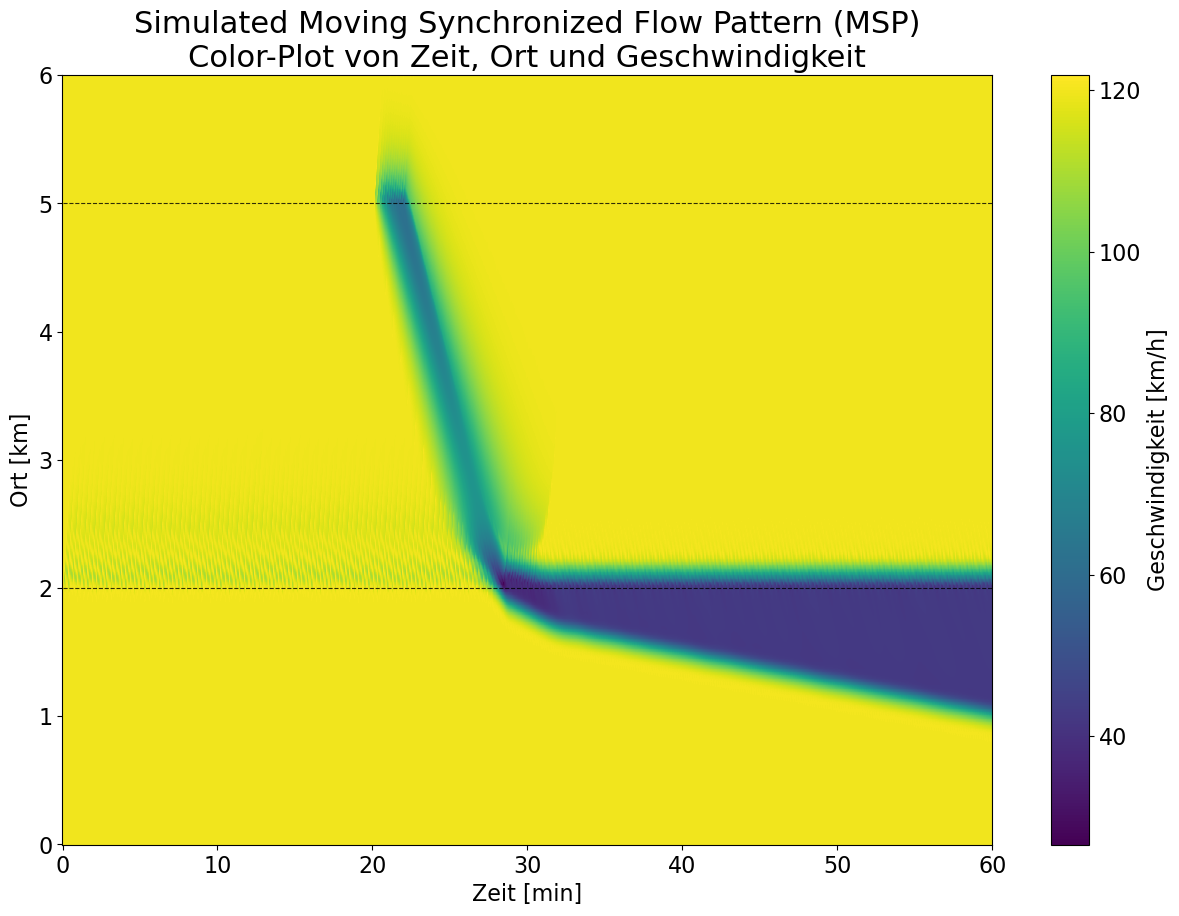

PyObject Text(0.5, 1.0, 'Simulated Moving Synchronized Flow Pattern (MSP)\nColor-Plot von Zeit, Ort und Geschwindigkeit')

In [49]:
figure(figsize=(15,10))
pcolormesh(t_vec_red, s_vec_distanz, v_interp_values, shading="auto")
plot((0,60),(2,2), "--", color="k", alpha=0.8, linewidth=0.8)
plot((0,60),(5,5), "--", color="k", alpha=0.8, linewidth=0.8)
cbar = colorbar()#label="Geschwindigkeit [km/h]")
cbar.set_label("Geschwindigkeit [km/h]", fontsize=16)  # Hier die Schriftgröße anpassen
cbar.ax.tick_params(labelsize=16)  # Hier die Schriftgröße anpassen
xlabel("Zeit [min]", fontsize=16)
ylabel("Ort [km]", fontsize=16)
xticks(fontsize=16)
yticks(fontsize=16)
title("Simulated Moving Synchronized Flow Pattern (MSP)\nColor-Plot von Zeit, Ort und Geschwindigkeit", fontsize=22)
#show()

#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Kerner Colorplot MSP.svg",bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Kerner Colorplot MSP.png",bbox_inches="tight")

## Plot mit imshow

In [20]:
#t_vec_red
#s_vec_distanz
#interp_values
Startzeit = now()
println("Startzeit = $Startzeit")
#Progressmeter 1
h100percent = size(v_interp_values)[1]
println("h100percent = $h100percent")
progress1_param1 = 0
progress1_param2 = 0

v_interp_values2 = zeros(size(v_interp_values)[1] , size(v_interp_values)[2])
for i in 1:size(v_interp_values)[1]
    #backrun_Index = size(interp_values)[1] + 1 - i
    for j in 1:size(v_interp_values)[2]
        v_interp_values2[i, j] = v_interp_values[size(v_interp_values)[1]+1-i, j]
    end
    
    #Progressmeter 1
    progress1_param1 = progress1_param1 + 1/h100percent
    if progress1_param1 ≥ 0.1
        progress1_param2 = progress1_param2 + 10
        jetzt = now()
        println("$jetzt   progress = $progress1_param2 %")
        progress1_param1 = progress1_param1 - 0.1
    end
end

Zielzeit = now()
println("Zielzeit = $Zielzeit")


Startzeit = 2024-01-13T21:53:51.067
h100percent = 1001
2024-01-13T21:53:51.372   progress = 10 %
2024-01-13T21:53:51.597   progress = 20 %
2024-01-13T21:53:51.819   progress = 30 %
2024-01-13T21:53:52.037   progress = 40 %
2024-01-13T21:53:52.250   progress = 50 %
2024-01-13T21:53:52.470   progress = 60 %
2024-01-13T21:53:52.685   progress = 70 %
2024-01-13T21:53:52.906   progress = 80 %
2024-01-13T21:53:53.129   progress = 90 %
Zielzeit = 2024-01-13T21:53:53.362


Matrix{Float64}
(1001, 3601)


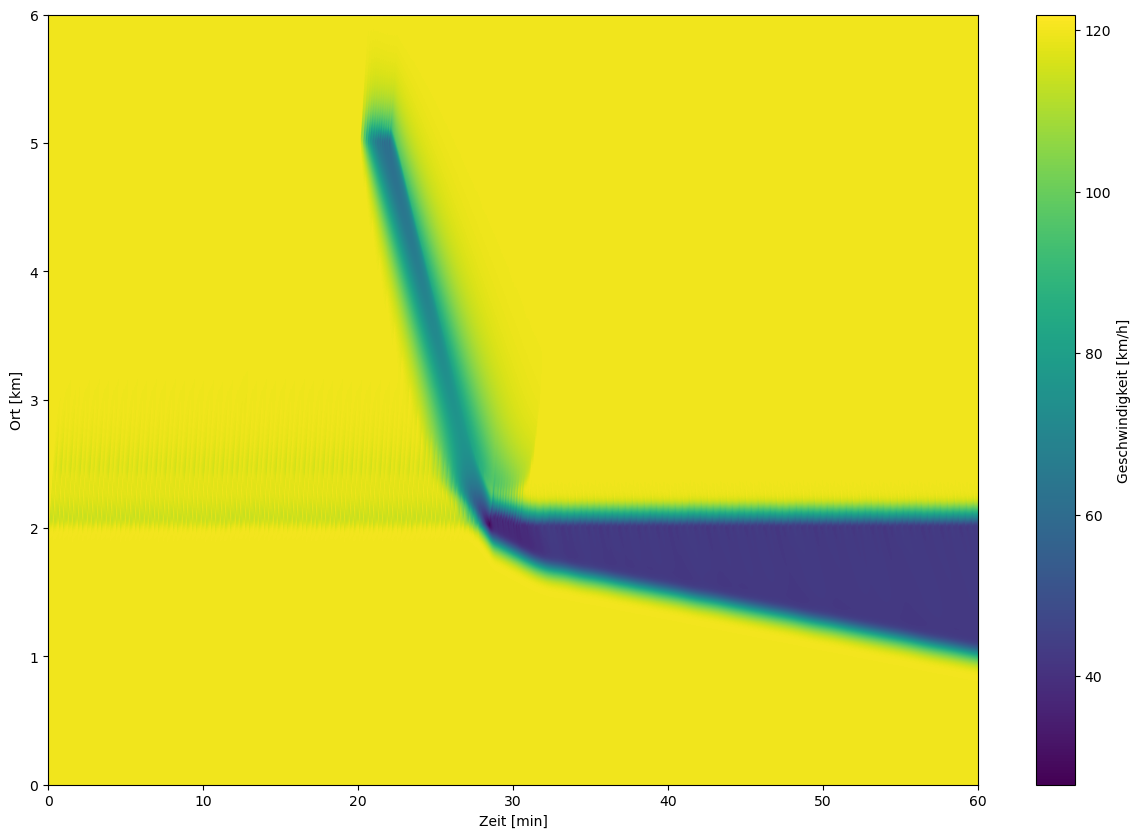

PyObject <matplotlib.colorbar.Colorbar object at 0x000001C57D80C2E0>

In [22]:
println(typeof(v_interp_values2))
println(size(v_interp_values2))

# Erstellen Sie eine Colormap
figure(figsize=(15,10))
imshow(v_interp_values2, aspect="auto", cmap="viridis",
    extent=[minimum(t_vec_red), maximum(t_vec_red), 0,
        #length(t_vec_red[1])
        L_input/10^3])
xlabel("Zeit [min]")
ylabel("Ort [km]")
colorbar(label="Geschwindigkeit [km/h]")


# Als Scatter-Plot mit nicht interpolierten Daten, aber reduzierter Datenmenge

In [50]:
Startzeit = now()
println("Startzeit    = $Startzeit")

# Beispielwerte (bitte mit den tatsächlichen Werten ersetzen)
#t_array = 0.0:5.0
#s_array = [rand(1:10, rand(3:5)) for _ in t_array]  # Beispiel-Ortsarray
#v_array = [rand(Float64, length(s_array[i])) for i in 1:length(s_array)]  # Beispiel-Geschwindigkeitsarray

#t_array0 = deepcopy(t_vec_export) / 60
#s_array0 = deepcopy(s_vec_export) / 1000
#v_array0 = 3.6 * deepcopy(v_vec_export)

reduction_param = 100

t_array = []
s_array = []
v_array = []

#Progressmeter 1
h100percent = length(t_vec_export)
progress1_param1 = 0
progress1_param2 = 0

for i in 1:length(t_vec_export)
    if mod(i-1, reduction_param) == 0
        #push!(t_array , t_array0[i])
        #push!(s_array , s_array0[i])
        #push!(v_array , v_array0[i])
        push!(t_array , t_vec_export[i]/60)
        push!(s_array , s_vec_export[i]/1000)
        push!(v_array , v_vec_export[i]*3.6)
    end
    #Progressmeter 1
    progress1_param1 = progress1_param1 + 1/h100percent
    if progress1_param1 ≥ 0.1
        progress1_param2 = progress1_param2 + 10
        println("progress1 = $progress1_param2 %")
        progress1_param1 = progress1_param1 - 0.1
    end
end

Zwischenzeit = now()
println("Zwischenzeit = $Zwischenzeit")

# Daten für das Color-Plot vorbereiten
x_vals = []  # Zeitwerte
y_vals = []  # Ortswerte
c_vals = []  # Geschwindigkeitswerte

#Progressmeter 2
h100percent2 = length(t_array)
progress2_param1 = 0
progress2_param2 = 0

for (t_Index, t_val) in enumerate(t_array)
    s_vals = s_array[t_Index]
    v_vals = v_array[t_Index]

    for (Index2, s_val) in enumerate(s_vals)
        push!(x_vals, t_val)
        push!(y_vals, s_val)
        push!(c_vals, v_vals[Index2])
    end
    #Progressmeter 2
    progress2_param1 = progress2_param1 + 1/h100percent2
    if progress2_param1 ≥ 0.1
        progress2_param2 = progress2_param2 + 10
        println("progress2 = $progress2_param2 %")
        progress2_param1 = progress2_param1 - 0.1
    end
end

#h100percent = length(t_array) 
#summy = [sum((test_vec[i]) for i in 3:5)]

Zielzeit = now()
println("Endzeit      = $Zielzeit")

Startzeit    = 2024-01-15T14:29:24.787
progress1 = 10 %
progress1 = 20 %
progress1 = 30 %
progress1 = 40 %
progress1 = 50 %
progress1 = 60 %
progress1 = 70 %
progress1 = 80 %
progress1 = 90 %
Zwischenzeit = 2024-01-15T14:29:25.166
progress2 = 10 %
progress2 = 20 %
progress2 = 30 %
progress2 = 40 %
progress2 = 50 %
progress2 = 60 %
progress2 = 70 %
progress2 = 80 %
progress2 = 90 %
Endzeit      = 2024-01-15T14:29:25.906


Startzeit = 2024-01-15T14:29:48.782
Endzeit   = 2024-01-15T14:29:53.382


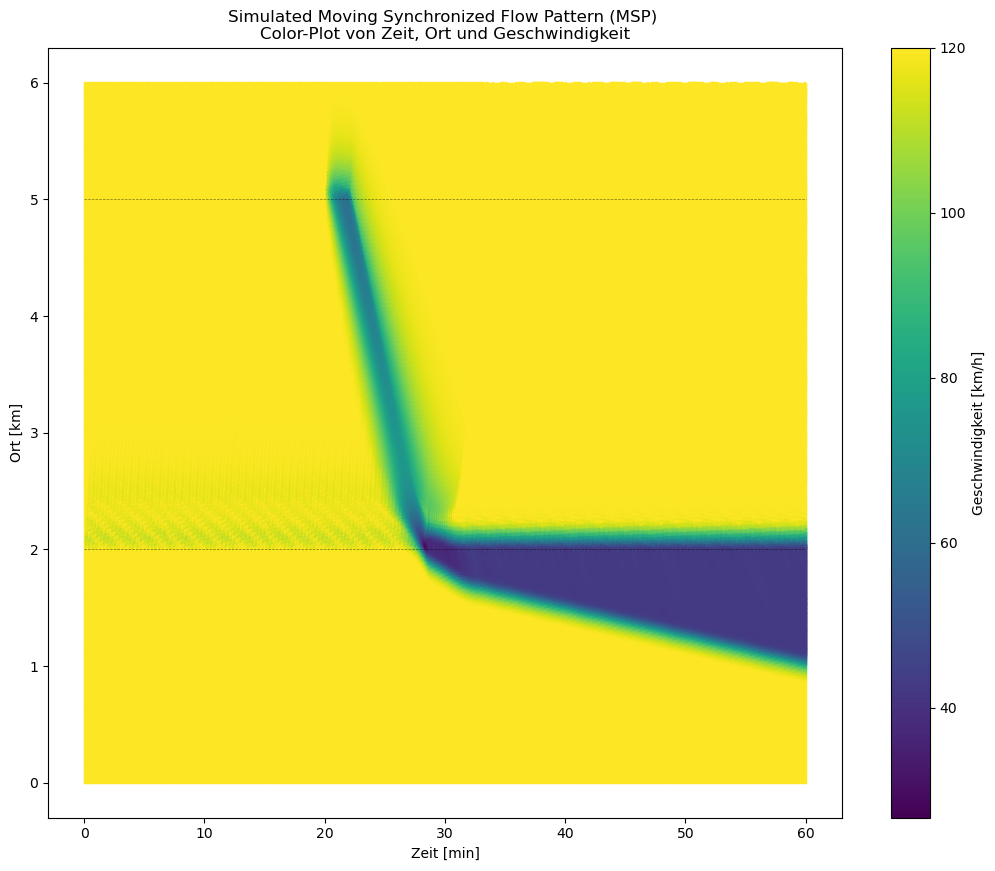

In [52]:
Startzeit = now()
println("Startzeit = $Startzeit")


figure(figsize=(12.8,10)) #(6.4,5)
# Color-Plot mit Rechtecken erstellen
scatter(x_vals, y_vals, c=c_vals, cmap="viridis", 
                marker=:s,
                #marker=:rect,
                s=1, #1
                linewidth=1)#, edgecolor="black")
plot((0,60), (x_on_b_input/1000     , x_on_b_input/1000)     , "--", linewidth=0.5, color="k", alpha=0.5)
plot((0,60), (x_on_b_down_input/1000, x_on_b_down_input/1000), "--", linewidth=0.5, color="k", alpha=0.5)

# Test: Größe der Squares / Bildauflösung
#scatter(10, 1, c= 80, cmap="viridis", marker=:s, s=1, linewidth=1)
#scatter(10+10/60, 1, c= 80, cmap="viridis", marker=:s, s=1, linewidth=1)
#scatter(10+10/60, 1+6/150, c= 120, cmap="viridis", marker=:s, s=1, linewidth=1)

colorbar(label="Geschwindigkeit [km/h]")

# Achsentitel und Beschriftungen hinzufügen
xlabel("Zeit [min]")
ylabel("Ort [km]")
title("Simulated Moving Synchronized Flow Pattern (MSP) \nColor-Plot von Zeit, Ort und Geschwindigkeit")

# Plot anzeigen
show()

Zielzeit = now()
println("Endzeit   = $Zielzeit")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Colorplot MSP.svg",bbox_inches="tight")
#savefig("C:/Users/Fliese/Desktop/Kerner-Modell/jupyter notebooks Kerner-Modell/Colorplot MSP neutest.png",bbox_inches="tight")

# Scatterplot mit Punkten

Startzeit = 2024-01-15T14:30:27.999
Endzeit   = 2024-01-15T14:30:32.550


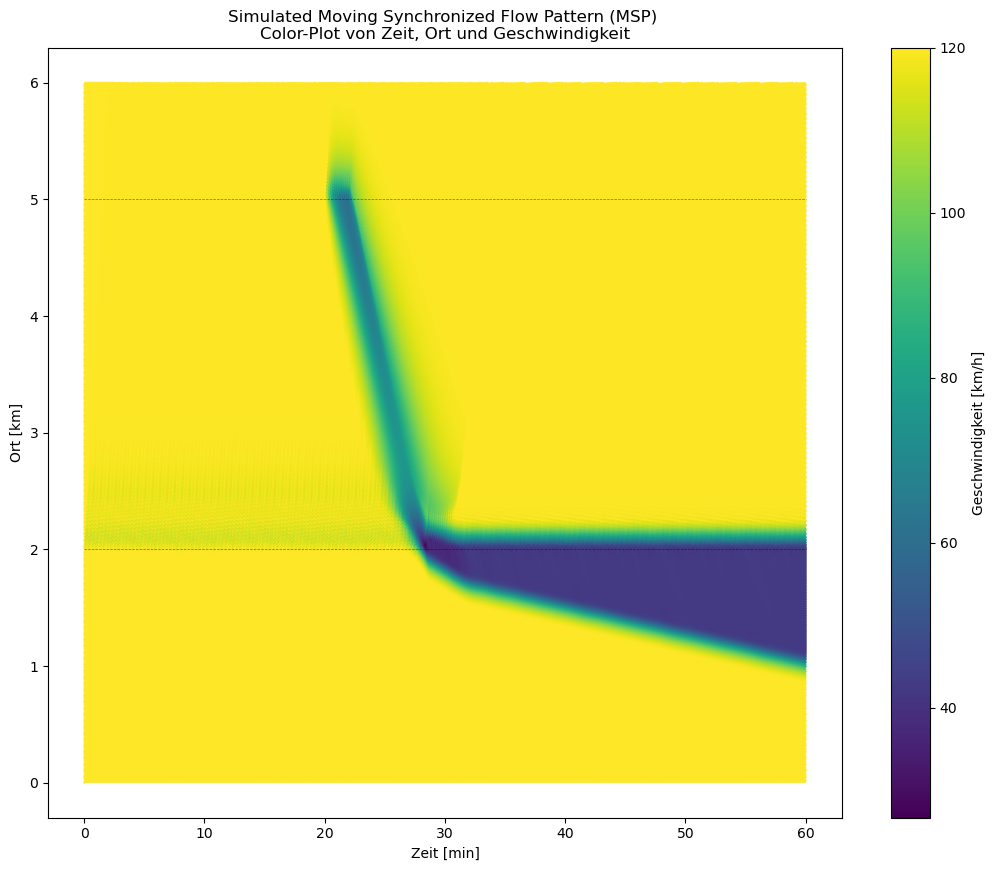

In [53]:
Startzeit = now()
println("Startzeit = $Startzeit")


figure(figsize=(12.8,10)) #(6.4,5)
# Color-Plot mit Rechtecken erstellen
scatter(x_vals, y_vals, c=c_vals, cmap="viridis", 
                marker=:.,
                #marker=:rect,
                s=1, #1
                linewidth=1)#, edgecolor="black")
plot((0,60), (x_on_b_input/1000     , x_on_b_input/1000)     , "--", linewidth=0.5, color="k", alpha=0.5)
plot((0,60), (x_on_b_down_input/1000, x_on_b_down_input/1000), "--", linewidth=0.5, color="k", alpha=0.5)

# Test: Größe der Squares / Bildauflösung
#scatter(10, 1, c= 80, cmap="viridis", marker=:s, s=1, linewidth=1)
#scatter(10+10/60, 1, c= 80, cmap="viridis", marker=:s, s=1, linewidth=1)
#scatter(10+10/60, 1+6/150, c= 120, cmap="viridis", marker=:s, s=1, linewidth=1)

colorbar(label="Geschwindigkeit [km/h]")

# Achsentitel und Beschriftungen hinzufügen
xlabel("Zeit [min]")
ylabel("Ort [km]")
title("Simulated Moving Synchronized Flow Pattern (MSP) \nColor-Plot von Zeit, Ort und Geschwindigkeit")

# Plot anzeigen
show()

Zielzeit = now()
println("Endzeit   = $Zielzeit")